# Lecture 6: NetCDF, OPeNDAP, Xarray, Cartopy, & PyGMT
Guest Lecture by Ty Janoski, Ph.D.

February 24th, 2026

## Today's Workflow

This lecture covers five tools that work together in a typical geospatial climate data workflow:

```
Climate Data
    │
    ▼
NetCDF (.nc files) ── the file format that stores labeled, multi-dimensional arrays
    │
    ▼
OPeNDAP ─────────── a protocol for accessing NetCDF data remotely (no download needed)
    │
    ▼
Xarray ──────────── a Python library for reading, manipulating, and slicing that data
    │
    ▼
Cartopy / PyGMT ─── Python libraries for visualizing the data on geographic maps
```

By the end of this lecture, you'll be able to pull climate model output from a remote server and produce publication-quality maps.

## NetCDF: Network Common Data Form

Sources for this section: 
- [CEDA Archive NetCDF Page](https://help.ceda.ac.uk/article/106-netcdf).
- [UCAR NetCDF Users Guide](https://docs.unidata.ucar.edu/nug/current/netcdf_introduction.html)
- [Data Carpentry for Oceanographers Introduction to netCDF](https://adyork.github.io/python-oceanography-lesson/17-Intro-NetCDF/index.html)

### Introduction to NetCDF

NetCDF is an **interface for accessing and manipulating labeled data arrays**. Although it is not *strictly* a file format, it can be thought of as such. NetCDF files will end with ".nc". Most climate, atmospheric, and ocean model data is distributed as netCDF files.

NetCDF has some advantages:
- Files are *self-describing*, i.e., they contain information about the data structure and attributes *in the files themselves* (called metadata)
- Platform independent and supported by many tools for data access
- Stored in binary format, which is storage-efficient
  
### NetCDF Structure

Data is stored as **labeled arrays** where each array has the same data type.

NetCDF files will typically have **variables**, **dimensions/coordinates**, and **attributes**.

![Xarray Dataset/NetCDF Diagram](https://howto.eurec4a.eu/_images/dataset-diagram.png)

#### Variables:

Variables are arrays of the same type that store the actual data (i.e., temperature, pressure, salinity). They will have a name, data type, and shape, where the shape corresponds to the dimensions describing the data.

![netCDF diagram](https://web.archive.org/web/20220908021359/https://www.esri.com/arcgis-blog/wp-content/uploads/2012/04/netCDF_SliceDiagram.png)
Source: [esri ArcGIS blog](https://www.esri.com/arcgis-blog/products/product/analytics/including-netcdf-dimension-values-in-the-name-of-an-output-layer-or-table/)

#### Dimensions:
Dimensions provide the shape information for data variables and may represent an actual physical dimension like latitude, longitude, height, or time. They have a name and size.

Coordinate arrays provide data that gives meaning to the dimensions. For example, there might be a "time" dimension of size 365 and a corresponding "time" coordinate array that holds the calendar date for each time.

#### Attributes:

Attributes *describe* the data such as providing information about map projections, units, or other helpful data properties.

### Accessing netCDF data

We will use OPeNDAP to access climate model output and the Python library Xarray to interface with it.

## OPeNDAP: Open-Source Project for a Network Data Access Protocol

Sources for this section: [OPeNDAP Tutorial](https://opendap.github.io/documentation/QuickStart.html)

![image.png](https://www.opendap.org/wp-content/uploads/2024/01/Logo-red-2.png)

OPeNDAP is **a data access protocol that lets you access data remotely**. This means that you do not have to download the data on your machine, which is very helpful for climate data that can be hundreds of TBs. Your computer can likely hold 1 TB.

Note that although we do not have to download the data, depending on what you are doing, you will still have to inevitably *load the data into your memory*. You have to be cognizant of your RAM (typically less than 32 GB on your personal machine) when working with climate data. Using tools like [dask](https://www.dask.org) can help you get around this, as well as being a smart programmer, but those are beyond the scope of this lecture.

Columbia has a server full of climate model output that is set up so that you can access it with OPeNDAP. All we need is a link and a library, like Xarray, to get started.

## Xarray: labelled multi-dimensional arrays

Sources for this section:
- [Xarray in 45 minutes](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)
- [Ryan Abernathey's Xarray Tutorial](https://rabernat.github.io/research_computing/xarray.html)
- [Project Pythia Introduction to Xarray Cookbook](https://foundations.projectpythia.org/core/xarray/xarray-intro/)

<img src="https://repository-images.githubusercontent.com/13221727/f43c8900-75c0-11ea-9e1b-66b0af0689e0" alt="drawing" width="500"/>

### Introduction & Gathering Data

We will be playing around with model output generated during the *Climate Model Intercomparison Project Phase 6 (CMIP6)*. In this experiment, modeling groups worldwide produced a standard set of simulations with their models.

The first step is to simply import Xarray. We will import NumPy and Matplotlib while we are at it.


In [1]:
# Import statements
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# These are some "magic" statements to make displaying plots a bit smoother
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we are going to "read in" one climate model simulation containing the 2 meter air temperature from one experiment. The model name is CESM (Community Earth System Model) and the experiment is "SSP585," meaning that this climate model simulation is forced according to the SSP585 (high fossil-fueled development) emissions scenario.

Notice how easy it is to use Xarray's `open_dataset()` function to access the data. All we need is the OPeNDAP link!

**Slight complication**: The data on Columbia’s server uses an invalid calendar format, which causes issues when Xarray tries to open it. I am going to provide a `fix_calendar()` function below. Do not worry about the specifics of what it is doing, but realize that in most cases outside of Columbia, you will not have to do this.

In [2]:
# Columbia's OPeNDAP server stores time with an unofficial "360" calendar label.
# Xarray requires the CF-compliant label "360_day". This function patches it.
# (You won't need this for most NetCDF files — it's specific to this server.)
# Note: the ': xr.Dataset' and '-> xr.Dataset' are optional type hints —
# they tell Python what types the function expects and returns. Don't worry about them
#  for now.
def fix_calendar(ds: xr.Dataset) -> xr.Dataset:
    """
    Overwrite the dataset's '360' calendar to a '360_day' to be CF-compliant.

    Input:
    ds: the Xarray Dataset whose calendar to fix. Time axis is called 'T'.

    Output:
    fixed: Xarray Dataset with fixed calendar
    """
    ds.T.attrs["calendar"] = "360_day"
    return xr.decode_cf(ds)


In [3]:
# URL for Columbia's OPeNDAP server. Reading the path left to right:
#   CMIP6i   → CMIP6 data archive
#   ssp585   → SSP5-8.5 "worst case" emissions scenario
#   Amon     → monthly atmospheric output
#   tas      → surface air temperature variable
#   CESM2    → Community Earth System Model v2
#   r1i1p1f1 → first ensemble member (one of many possible model runs)
url = (
    "http://mary.ldeo.columbia.edu:81/CMIP6i/.byScenario/.ssp585/.Amon/"
    + ".tas/.CESM2/.gn/.r1i1p1f1/.tas/dods"
)
LOCAL_FILE = "tas_CESM2_ssp585_2015-2025.nc"

try:
    ds = xr.open_dataset(url, decode_times=False)  # decode_times=False:
    # let fix_calendar handle it
    ds = fix_calendar(ds)
    print("Loaded from OPeNDAP (full dataset: 2015–2100).")
except Exception as e:
    # If the server is unavailable, load a pre-downloaded local copy
    print(f"OPeNDAP unavailable ({e})\nLoading local fallback (2015–2025).")
    ds = xr.open_dataset(LOCAL_FILE)

# Look at ds
ds


Loaded from OPeNDAP (full dataset: 2015–2100).


<xarray.Dataset> Size: 228MB
Dimensions:  (T: 1032, lat: 192, lon: 288)
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (T, lat, lon) float32 228MB ...
Attributes:
    Conventions:  IRIDL

Xarray's `open_dataset()` function has several arguments, which refer to optional keyword arguments (also called parameters) in programming. Here are a few to know:
- `engine`: specifies the underlying backend to interpret the files. Xarray is "guessing" to use `netcdf4` for the file we opened, but depending on the data, you can alternatively use `h5netcdf` or `zarr` among others
- `decode_cf` and `decode_times`: set these to `False` if Xarray encounters issues interpreting the calendar or metadata in the file.
- `drop_variables`: can give a string or list of strings to specify variables you do not want to read in from the netCDF file.
- `open_mfdataset()`: use instead of `open_dataset()` when you have **multiple files** to open at once (e.g., one file per year). Xarray concatenates them automatically.

### Datasets \& DataArrays

Datasets and DataArrays are the fundamental labeled array containers in Xarray. We’ve read in a Dataset, which stores data variables as individual DataArrays. Look what happens if we pull out the "tas" variable that contains the surface air temperature.

In [4]:
# Extract with dictionary syntax
ds["tas"]

<xarray.DataArray 'tas' (T: 1032, lat: 192, lon: 288)> Size: 228MB
[57065472 values with dtype=float32]
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

In [5]:
# Extract with dot notation
ds.tas

# Both methods return a DataArray object

<xarray.DataArray 'tas' (T: 1032, lat: 192, lon: 288)> Size: 228MB
[57065472 values with dtype=float32]
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

DataArrays contain dimensions, coordinates, and attributes, just like variables in a NetCDF file.

In [6]:
# Assign tas to a variable so we don't have to keep typing ds.tas
tas = ds.tas

# Print some metadata
print(f"DataArray name: {tas.name}")
print(f"Named dimensions: {tas.dims}")
print(f"Coordinates:\n{tas.coords}")

DataArray name: tas
Named dimensions: ('T', 'lat', 'lon')
Coordinates:
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8


`dims` are our data axes, while `coords` are our labeled coordinate variables. This is an easy example because all of our coordinates are one-dimensional, but this won't always be the case!

Let's also check out the attrs.

In [7]:
tas.attrs

{'time_title': 'Temporal mean',
 'description': 'near-surface (usually, 2 meter) air temperature',
 'standard_name': 'air_temperature',
 'units': 'Kelvin_scale',
 'time_label': 'time-mean',
 'cell_methods': 'area: time: mean',
 'variable_id': 'tas',
 'mipTable': 'Amon',
 'comment': 'TREFHT',
 'title': 'Near-Surface Air Temperature',
 'realm': 'atmos',
 'id': 'tas',
 'frequency': 'mon',
 'long_name': 'Near-Surface Air Temperature',
 'out_name': 'tas',
 'prov': 'Amon ((isd.003))',
 'cell_measures': 'area: areacella'}

We can extract the underlying data from a DataArray as an unlabeled NumPy array. This is useful sometimes when we need to perform operations that aren’t compatible with Xarray or we need to feed the data into another library.

This might take a second because now we are **loading the data into memory**.

In [8]:
tas.data # This is equivalent to tas.values

array([[[245.4768 , 245.4768 , 245.47675, ..., 245.47682, 245.47682,
         245.47682],
        [246.26842, 246.2407 , 246.09692, ..., 246.27731, 246.27814,
         246.27635],
        [246.77779, 246.75319, 246.76334, ..., 246.95198, 246.92142,
         246.86867],
        ...,
        [250.46544, 250.49406, 250.52039, ..., 250.39522, 250.41864,
         250.44012],
        [249.611  , 249.62094, 249.63054, ..., 249.57242, 249.58525,
         249.59886],
        [248.57834, 248.58159, 248.58453, ..., 248.56648, 248.57085,
         248.57478]],

       [[235.5389 , 235.5389 , 235.5389 , ..., 235.5389 , 235.5389 ,
         235.5389 ],
        [236.26709, 236.22263, 236.05812, ..., 236.33438, 236.30482,
         236.2897 ],
        [236.9475 , 236.8905 , 236.85217, ..., 237.22475, 237.15656,
         237.07187],
        ...,
        [247.25343, 247.29446, 247.33432, ..., 247.14085, 247.17653,
         247.21262],
        [247.5313 , 247.55113, 247.57227, ..., 247.47136, 247.49174,
   

Let's check the data size and type.

In [9]:
type(tas.data)

numpy.ndarray

In [10]:
# Get size, divide by 10**6 to make it MB
tas.nbytes/1e6

228.261888

That’s 228 MB — pretty big for a variable with just three dimensions. Can you imagine how big a file containing vertically varying air temperature (with 30+ levels) would be?

### Xarray Comparison

Xarray lets us manipulate and visualize data much more easily than using the more basic (but important!) libraries like NumPy or Scipy. Consider how we might visualize this data without Xarray.

This is an example of how you should **not** do it!

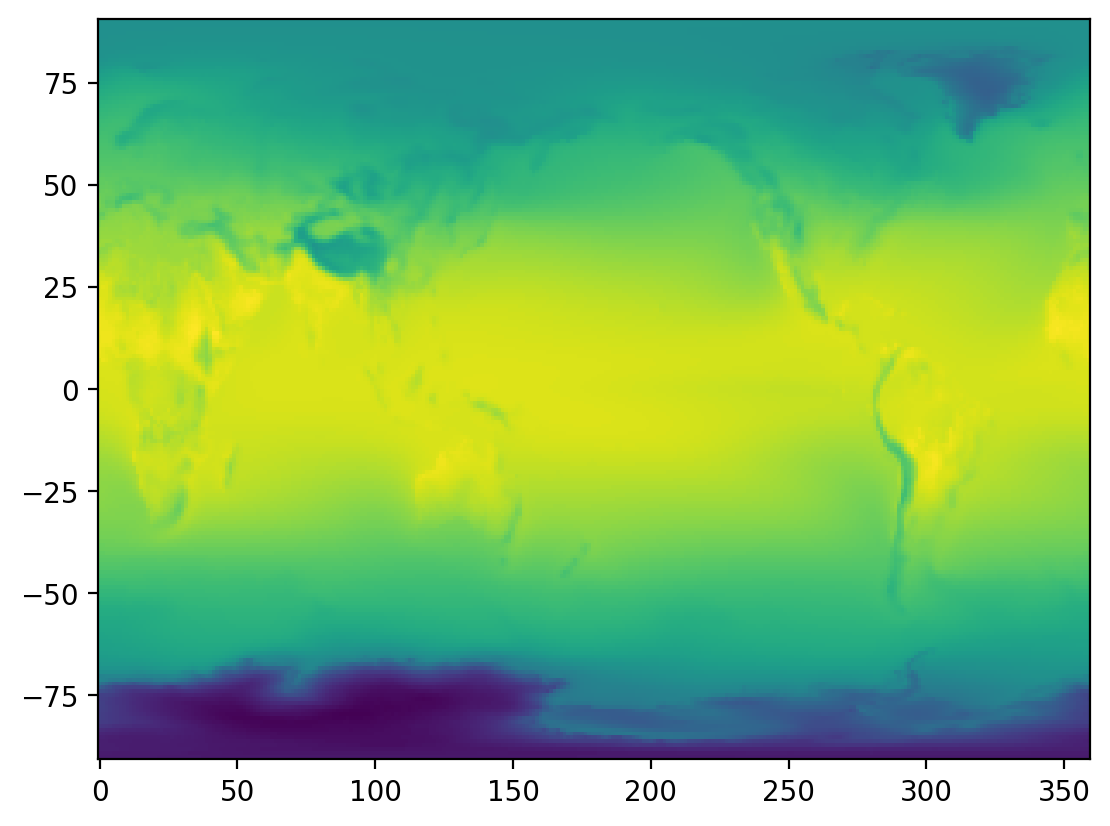

In [11]:
# Get data and coordinates to plot it
# This approach requires manually handling data, slicing, and plotting — not ideal!
lat_data = ds.lat.data
lon_data = ds.lon.data
tas_data = ds.tas.data

# Take the time mean
tas_mean = tas_data.mean(axis=0)

# Now plot it
plt.figure()
plt.pcolormesh(lon_data,lat_data,tas_mean)

Xarray uses the names and coordinates of variables to perform similar operations and plotting, so it is much more readable.

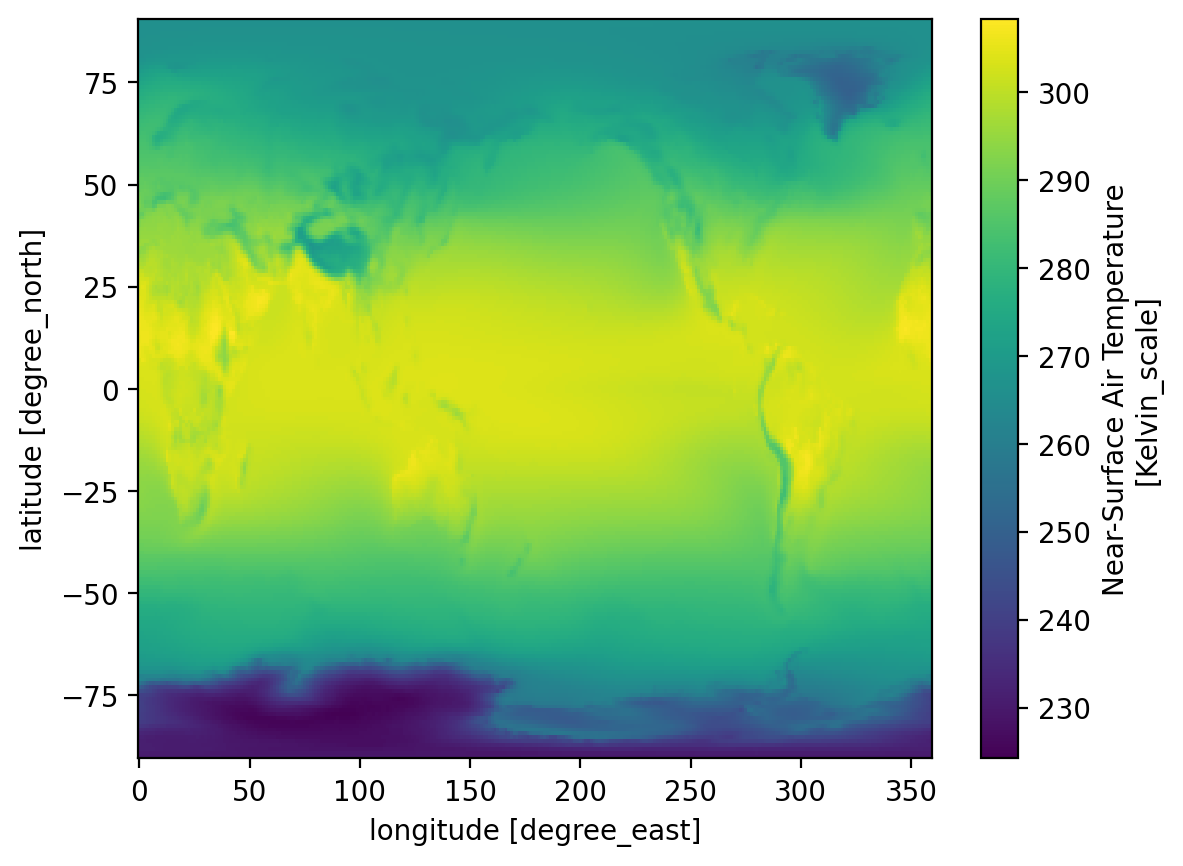

In [12]:
# One line for the same plot
tas.mean(dim="T").plot(x="lon")

Look, it even gave us axis labels and a colorbar! Of course we can override any of these properties to beautify the plot however we'd like, but this just shows how much more usable Xarray is. Here, we’re clearly taking the mean along the "T" (time) axis and plotting the result using longitude as the x-axis.

### Slicing and dicing data

#### Positional Indexing

Xarray gives us several different ways to subset data, i.e., select which data we want to analyze or plot. The first is similar to how we subset NumPy arrays.

In [13]:
# Reminder: tas is our DataArray holding the surface air temperature with dimensions of T, lat, and lon
# Get the first time
tas[0,:,:]

<xarray.DataArray 'tas' (lat: 192, lon: 288)> Size: 221kB
array([[245.4768 , 245.4768 , 245.47675, ..., 245.47682, 245.47682, 245.47682],
       [246.26842, 246.2407 , 246.09692, ..., 246.27731, 246.27814, 246.27635],
       [246.77779, 246.75319, 246.76334, ..., 246.95198, 246.92142, 246.86867],
       ...,
       [250.46544, 250.49406, 250.52039, ..., 250.39522, 250.41864, 250.44012],
       [249.611  , 249.62094, 249.63054, ..., 249.57242, 249.58525, 249.59886],
       [248.57834, 248.58159, 248.58453, ..., 248.56648, 248.57085, 248.57478]],
      shape=(192, 288), dtype=float32)
Coordinates:
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    T        object 8B 2015-01-16 00:00:00
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

In [14]:
# Or a range...
tas[0:5,:,:]

<xarray.DataArray 'tas' (T: 5, lat: 192, lon: 288)> Size: 1MB
array([[[245.4768 , 245.4768 , ..., 245.47682, 245.47682],
        [246.26842, 246.2407 , ..., 246.27814, 246.27635],
        ...,
        [249.611  , 249.62094, ..., 249.58525, 249.59886],
        [248.57834, 248.58159, ..., 248.57085, 248.57478]],

       [[235.5389 , 235.5389 , ..., 235.5389 , 235.5389 ],
        [236.26709, 236.22263, ..., 236.30482, 236.2897 ],
        ...,
        [247.5313 , 247.55113, ..., 247.49174, 247.51158],
        [247.86192, 247.86183, ..., 247.86215, 247.86203]],

       ...,

       [[220.36047, 220.36049, ..., 220.36047, 220.36047],
        [220.70654, 220.67717, ..., 220.71173, 220.71068],
        ...,
        [256.477  , 256.48492, ..., 256.46106, 256.4693 ],
        [256.8423 , 256.84174, ..., 256.84357, 256.8429 ]],

       [[220.89037, 220.89037, ..., 220.89037, 220.89037],
        [220.6619 , 220.6328 , ..., 220.6708 , 220.66731],
        ...,
        [267.9156 , 267.91208, ..., 267.9226 , 267.91913],
        [267.96826, 267.9678 , ..., 267.9694 , 267.9688 ]]],
      shape=(5, 192, 288), dtype=float32)
Coordinates:
  * T        (T) object 40B 2015-01-16 00:00:00 ... 2015-05-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

Remember: this isn't NumPy, this is **Xarray!** There has to be a better way to index.

Xarray's main advantage is that the arrays are *labeled*. That means instead of memorizing the dimension/coordinate order, we can call them by name using `.isel()`.

In [15]:
# Get the first time
tas.isel(T=0)

<xarray.DataArray 'tas' (lat: 192, lon: 288)> Size: 221kB
array([[245.4768 , 245.4768 , 245.47675, ..., 245.47682, 245.47682, 245.47682],
       [246.26842, 246.2407 , 246.09692, ..., 246.27731, 246.27814, 246.27635],
       [246.77779, 246.75319, 246.76334, ..., 246.95198, 246.92142, 246.86867],
       ...,
       [250.46544, 250.49406, 250.52039, ..., 250.39522, 250.41864, 250.44012],
       [249.611  , 249.62094, 249.63054, ..., 249.57242, 249.58525, 249.59886],
       [248.57834, 248.58159, 248.58453, ..., 248.56648, 248.57085, 248.57478]],
      shape=(192, 288), dtype=float32)
Coordinates:
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    T        object 8B 2015-01-16 00:00:00
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

We can also get a range, but it will look a bit different because we will use the `slice()` function.

In [16]:
# Get the first five times
tas.isel(T=slice(0,5)) # Note: we can use None instead of 0 here for the same result

<xarray.DataArray 'tas' (T: 5, lat: 192, lon: 288)> Size: 1MB
array([[[245.4768 , 245.4768 , ..., 245.47682, 245.47682],
        [246.26842, 246.2407 , ..., 246.27814, 246.27635],
        ...,
        [249.611  , 249.62094, ..., 249.58525, 249.59886],
        [248.57834, 248.58159, ..., 248.57085, 248.57478]],

       [[235.5389 , 235.5389 , ..., 235.5389 , 235.5389 ],
        [236.26709, 236.22263, ..., 236.30482, 236.2897 ],
        ...,
        [247.5313 , 247.55113, ..., 247.49174, 247.51158],
        [247.86192, 247.86183, ..., 247.86215, 247.86203]],

       ...,

       [[220.36047, 220.36049, ..., 220.36047, 220.36047],
        [220.70654, 220.67717, ..., 220.71173, 220.71068],
        ...,
        [256.477  , 256.48492, ..., 256.46106, 256.4693 ],
        [256.8423 , 256.84174, ..., 256.84357, 256.8429 ]],

       [[220.89037, 220.89037, ..., 220.89037, 220.89037],
        [220.6619 , 220.6328 , ..., 220.6708 , 220.66731],
        ...,
        [267.9156 , 267.91208, ..., 267.9226 , 267.91913],
        [267.96826, 267.9678 , ..., 267.9694 , 267.9688 ]]],
      shape=(5, 192, 288), dtype=float32)
Coordinates:
  * T        (T) object 40B 2015-01-16 00:00:00 ... 2015-05-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

This is great, but it requires us to have some prerequisite knowledge of the coordinates. Next, we will show how you can use the `.sel()` function.

#### Label-based indexing

This is similar to how indexing works in Pandas. We can use `.sel()` to directly reference coordinate names and values!

In [17]:
# Get the data just for July of model-year 2016
tas.sel(T="2016-07") # Normally YYYY-MM(-DD) format

<xarray.DataArray 'tas' (T: 1, lat: 192, lon: 288)> Size: 221kB
array([[[221.23204, 221.23204, ..., 221.23204, 221.23204],
        [221.40077, 221.37462, ..., 221.40108, 221.40018],
        ...,
        [272.81418, 272.81473, ..., 272.81284, 272.8136 ],
        [272.82104, 272.82104, ..., 272.82104, 272.82104]]],
      shape=(1, 192, 288), dtype=float32)
Coordinates:
  * T        (T) object 8B 2016-07-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

In [18]:
# And a range...
# Get all data from January to December 2016
tas.sel(T=slice("2016-01","2016-12"))

<xarray.DataArray 'tas' (T: 12, lat: 192, lon: 288)> Size: 3MB
array([[[246.80734, 246.80734, ..., 246.80734, 246.80734],
        [247.41548, 247.35979, ..., 247.47064, 247.44446],
        ...,
        [244.92966, 244.93996, ..., 244.90758, 244.91914],
        [245.0727 , 245.07285, ..., 245.07236, 245.07253]],

       [[237.77527, 237.77527, ..., 237.77525, 237.77525],
        [238.2956 , 238.25507, ..., 238.32004, 238.30713],
        ...,
        [248.87479, 248.88286, ..., 248.85747, 248.86646],
        [248.86069, 248.86118, ..., 248.85957, 248.86015]],

       ...,

       [[236.95663, 236.95663, ..., 236.95663, 236.95663],
        [237.58551, 237.54858, ..., 237.6172 , 237.60143],
        ...,
        [256.29605, 256.29352, ..., 256.29895, 256.29794],
        [255.908  , 255.90941, ..., 255.90472, 255.90645]],

       [[246.16432, 246.16432, ..., 246.16432, 246.16434],
        [246.90659, 246.86021, ..., 246.9471 , 246.92903],
        ...,
        [250.09567, 250.11105, ..., 250.06467, 250.08044],
        [250.4807 , 250.48059, ..., 250.48096, 250.48082]]],
      shape=(12, 192, 288), dtype=float32)
Coordinates:
  * T        (T) object 96B 2016-01-16 00:00:00 ... 2016-12-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

Notice how we use the Python built-in `slice()` function to specify our slice.

But what if we don't know the *exact* position along a coordinate variable to index our data? Thankfully, Xarray allows us to perform nearest-neighbor sampling.

Say we wanted the data for New York City, which is approximately 40.7°N and 74°W.

#### Nearest-Neighbor Sampling

In [21]:
# Set the latitude and longitude of nyc
nyc_lat, nyc_lon = 40.7, 360-74 # convert to degrees east

tas_nyc = tas.sel(lat=nyc_lat,lon=nyc_lon,method="nearest")
tas_nyc

<xarray.DataArray 'tas' (T: 1032)> Size: 4kB
array([274.2869 , 276.10864, 283.31595, ..., 293.099  , 287.78046, 283.50964],
      shape=(1032,), dtype=float32)
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    lat      float32 4B 40.99
    lon      float32 4B 286.2
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

It's good practice to verify the results of using nearest-neighbor interpolation, but know that there is also a `tolerance` keyword argument if you want to make sure the result is close to what you wanted.

#### Interpolation

If nearest-neighbor sampling is not enough, we can even interpolate to the exact point of New York City. By default, it will use bilinear interpolation, but there are many other options that can be seen [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html).

In [22]:
# Interpolate to NYC
tas_nyc = tas.interp(lat=nyc_lat,lon=nyc_lon)
tas_nyc

<xarray.DataArray 'tas' (T: 1032)> Size: 8kB
array([275.35635135, 276.94004467, 283.8071973 , ..., 294.01189114,
       288.82826896, 284.50365998], shape=(1032,))
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
    lat      float64 8B 40.7
    lon      int64 8B 286
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          Kelvin_scale
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

Just for fun, let's plot it. It's going to look messy because any signal is **masked by the noise of seasons**. We will address this in the next section.

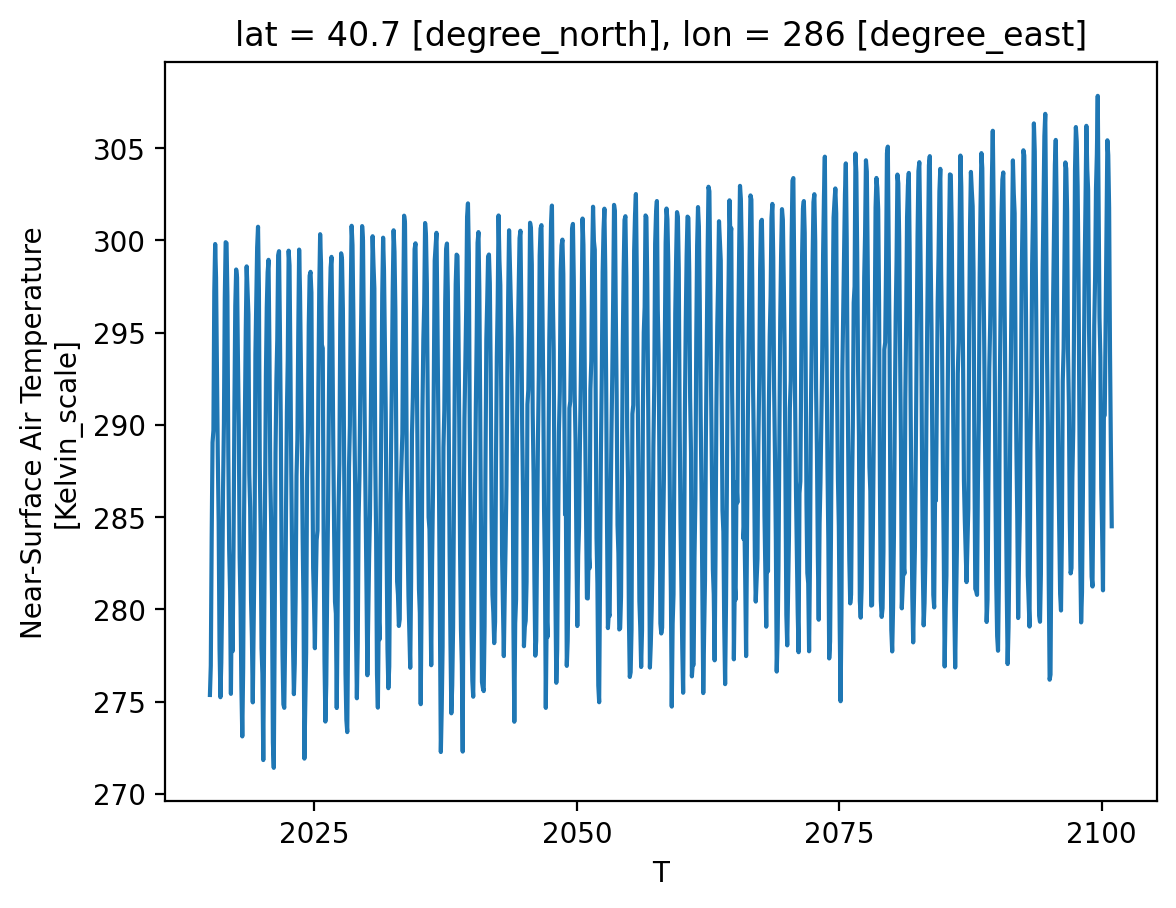

In [23]:
tas_nyc.plot()

### Computation with Xarray

#### Arithmetic & NumPy

For the most part, Xarray DataArrays and Datasets work intuitively with arithmetic and NumPy operations.

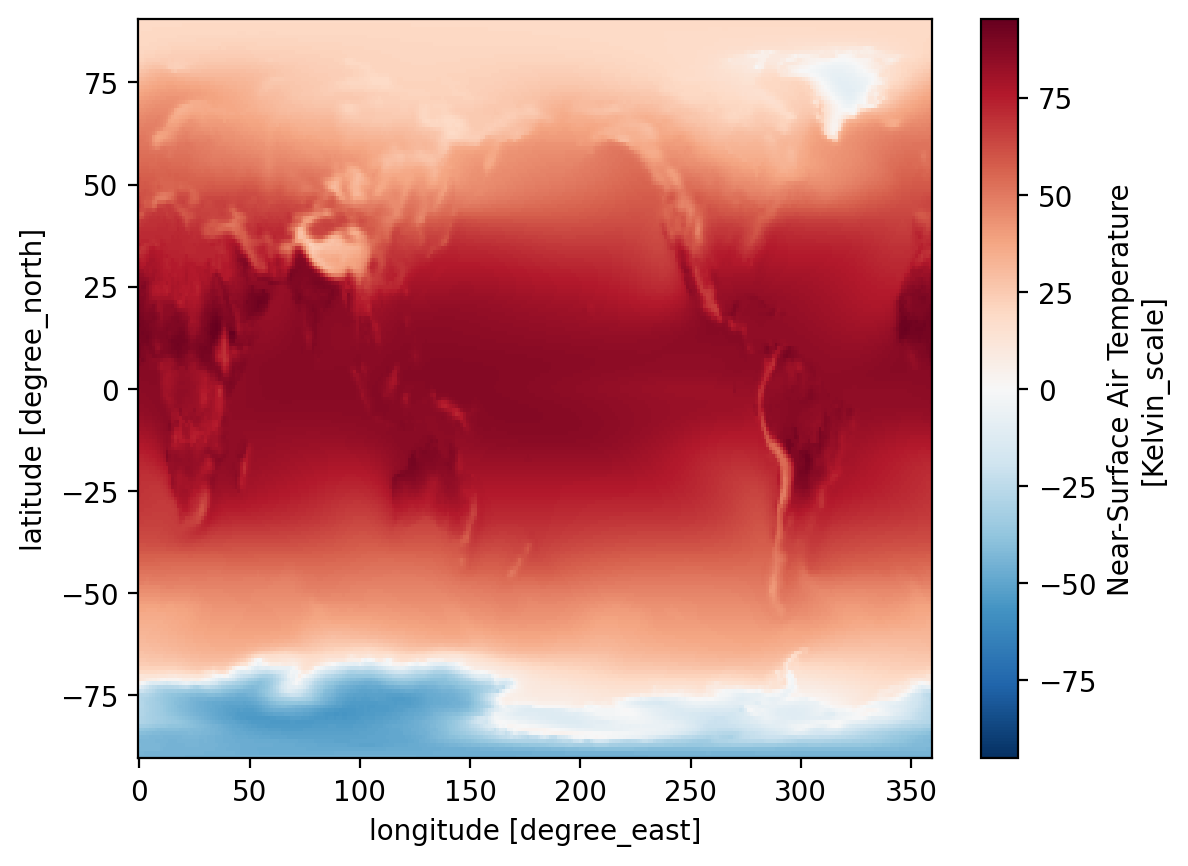

In [27]:
# Convert the temperature from Kelvin to Fahrenheit
tas_F = (tas - 273.15) * (9/5) + 32
tas_F.mean(dim="T").plot()

tas_F.attrs["units"] = "deg F"

In [28]:
tas_F

<xarray.DataArray 'tas' (T: 1032, lat: 192, lon: 288)> Size: 228MB
array([[[-17.811737 , -17.811737 , -17.811844 , ..., -17.811707 ,
         -17.811707 , -17.811707 ],
        [-16.386837 , -16.436714 , -16.695526 , ..., -16.370823 ,
         -16.369339 , -16.372555 ],
        [-15.469971 , -15.514248 , -15.495983 , ..., -15.156422 ,
         -15.211437 , -15.306385 ],
        ...,
        [ -8.832199 ,  -8.780674 ,  -8.733295 , ...,  -8.958595 ,
          -8.916435 ,  -8.877766 ],
        [-10.370201 , -10.352295 , -10.335018 , ..., -10.439636 ,
         -10.416538 , -10.392036 ],
        [-12.228977 , -12.223129 , -12.217827 , ..., -12.25032  ,
         -12.242462 , -12.235378 ]],

       [[-35.699974 , -35.699974 , -35.699974 , ..., -35.699974 ,
         -35.699974 , -35.699974 ],
        [-34.38923  , -34.46926  , -34.765373 , ..., -34.268105 ,
         -34.321304 , -34.34852  ],
        [-33.164497 , -33.267082 , -33.336075 , ..., -32.665443 ,
         -32.788185 , -32.94062  ],
...
          33.37395  ,  33.378235 ],
        [ 33.28249  ,  33.2854   ,  33.288532 , ...,  33.27172  ,
          33.27595  ,  33.279358 ],
        [ 33.260296 ,  33.260406 ,  33.26057  , ...,  33.259747 ,
          33.25991  ,  33.26013  ]],

       [[ -5.1708946,  -5.1709213,  -5.1708946, ...,  -5.1708946,
          -5.1708946,  -5.1709213],
        [ -3.6745834,  -3.7436333,  -4.0035706, ...,  -3.6629944,
          -3.6602745,  -3.665741 ],
        [ -2.863491 ,  -2.8944168,  -2.8959846, ...,  -2.5473595,
          -2.6077576,  -2.7022934],
        ...,
        [ 30.99854  ,  31.007496 ,  31.016174 , ...,  30.974865 ,
          30.982721 ,  30.990246 ],
        [ 30.89884  ,  30.902851 ,  30.906971 , ...,  30.884998 ,
          30.889887 ,  30.894556 ],
        [ 30.788757 ,  30.789196 ,  30.789581 , ...,  30.78711  ,
          30.787714 ,  30.788263 ]]],
      shape=(1032, 192, 288), dtype=float32)
Coordinates:
  * T        (T) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes: (12/17)
    time_title:     Temporal mean
    description:    near-surface (usually, 2 meter) air temperature
    standard_name:  air_temperature
    units:          deg F
    time_label:     time-mean
    cell_methods:   area: time: mean
    ...             ...
    id:             tas
    frequency:      mon
    long_name:      Near-Surface Air Temperature
    out_name:       tas
    prov:           Amon ((isd.003))
    cell_measures:  area: areacella

Let's take a step further and calculate the *saturation vapor pressure* from our data! We will use an approximation of the Clausius-Clapeyron relationship. You don't have to worry about how we got this equation, just how we implement it.

$e_s(T) = 6.112 \times exp(\frac{17.67\cdot T}{T + 243.5})$ where T is the temperature in °C

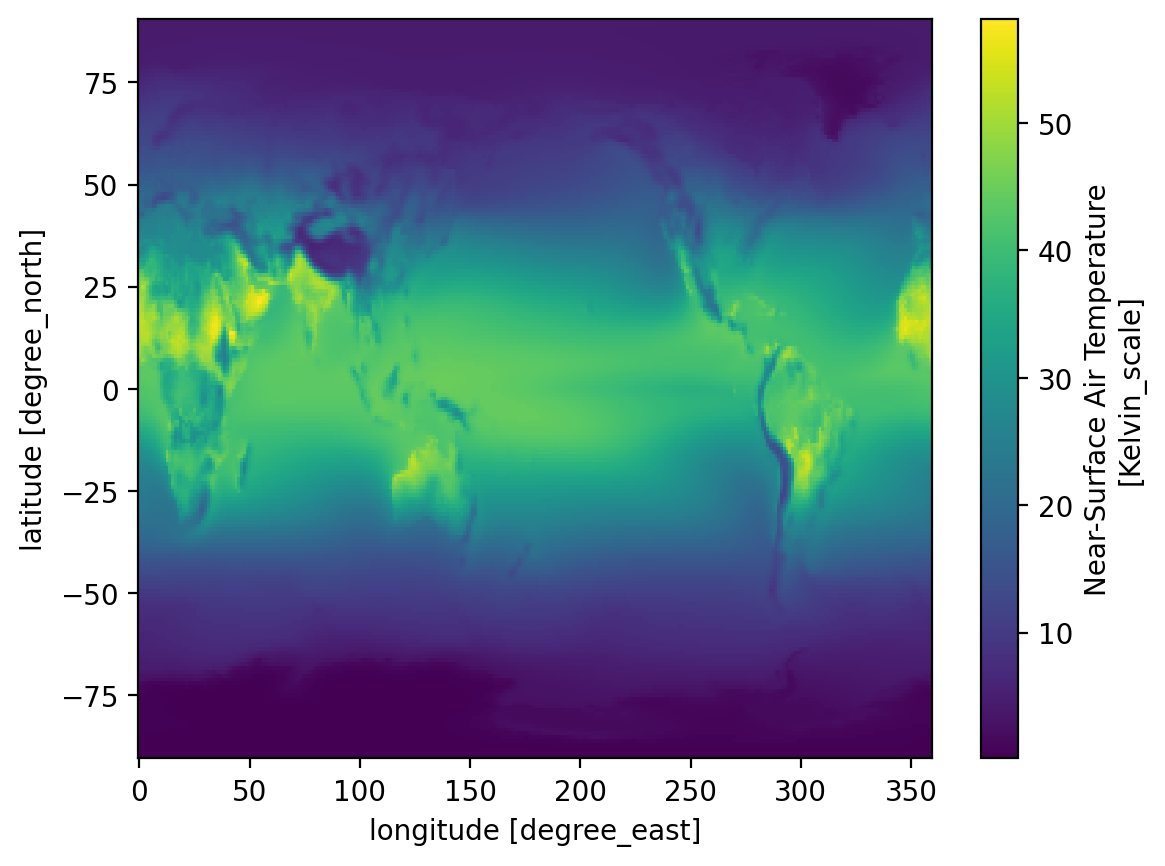

In [29]:
# Convert to C
tas_C = tas-273.15

# compute saturation vapor pressure
es = 6.112 * np.exp((17.67*tas_C)/(tas_C+243.5))
es.rename("es").mean(dim="T").plot()

Even though we applied a NumPy function, the result remained a DataArray because Xarray preserves metadata during operations.

#### Broadcasting / Aligning

Broadcasting refers to finding a common array shape when performing operations with arrays that have different shapes. Xarray is *excellent* at broadcasting and does so without much user input, although there are functions like `broadcast()` for explicit broadcasting.

If we multiply the lat and the lon, Xarray automatically creates a new 2-dimensional DataArray with lat and lon dimensions.

In [30]:
ds.lat * ds.lon

<xarray.DataArray (lat: 192, lon: 288)> Size: 221kB
array([[    -0.      ,   -112.5     ,   -225.      , ..., -32062.5     ,
        -32175.      , -32287.5     ],
       [    -0.      ,   -111.32199 ,   -222.64398 , ..., -31726.768   ,
        -31838.09    , -31949.412   ],
       [    -0.      ,   -110.143974,   -220.28795 , ..., -31391.033   ,
        -31501.178   , -31611.32    ],
       ...,
       [     0.      ,    110.143974,    220.28795 , ...,  31391.033   ,
         31501.178   ,  31611.32    ],
       [     0.      ,    111.32199 ,    222.64398 , ...,  31726.768   ,
         31838.09    ,  31949.412   ],
       [     0.      ,    112.5     ,    225.      , ...,  32062.5     ,
         32175.      ,  32287.5     ]], shape=(192, 288), dtype=float32)
Coordinates:
  * lat      (lat) float32 768B -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float32 1kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    modulus:  360.0

**Watch out: mismatched coordinates.** If two DataArrays share a dimension name but have slightly different coordinate values (e.g., due to floating-point differences or different grids), Xarray aligns them before operating — and points that don't match get dropped or filled with `NaN`. This is a common source of silent bugs in real research workflows. When results look unexpectedly empty or full of `NaN`, check whether your coordinates actually align.

#### Groupby

`groupby()` lets us bin data into groups and reduce. In other words, we can reorganize our data by sorting it into different categories. This is commonly done along the time axis.

In [31]:
# groupby the season
tas.groupby("T.season")

<DataArrayGroupBy, grouped over 1 grouper(s), 4 groups in total:
    'season': UniqueGrouper('season'), 4/4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'>

Notice that using `groupby()` just creates a DataArrayGroupBy object. The result isn’t directly usable yet, but notice how Xarray correctly identified meteorological seasons. We need to call another function to tell Xarray what to do with the groups.

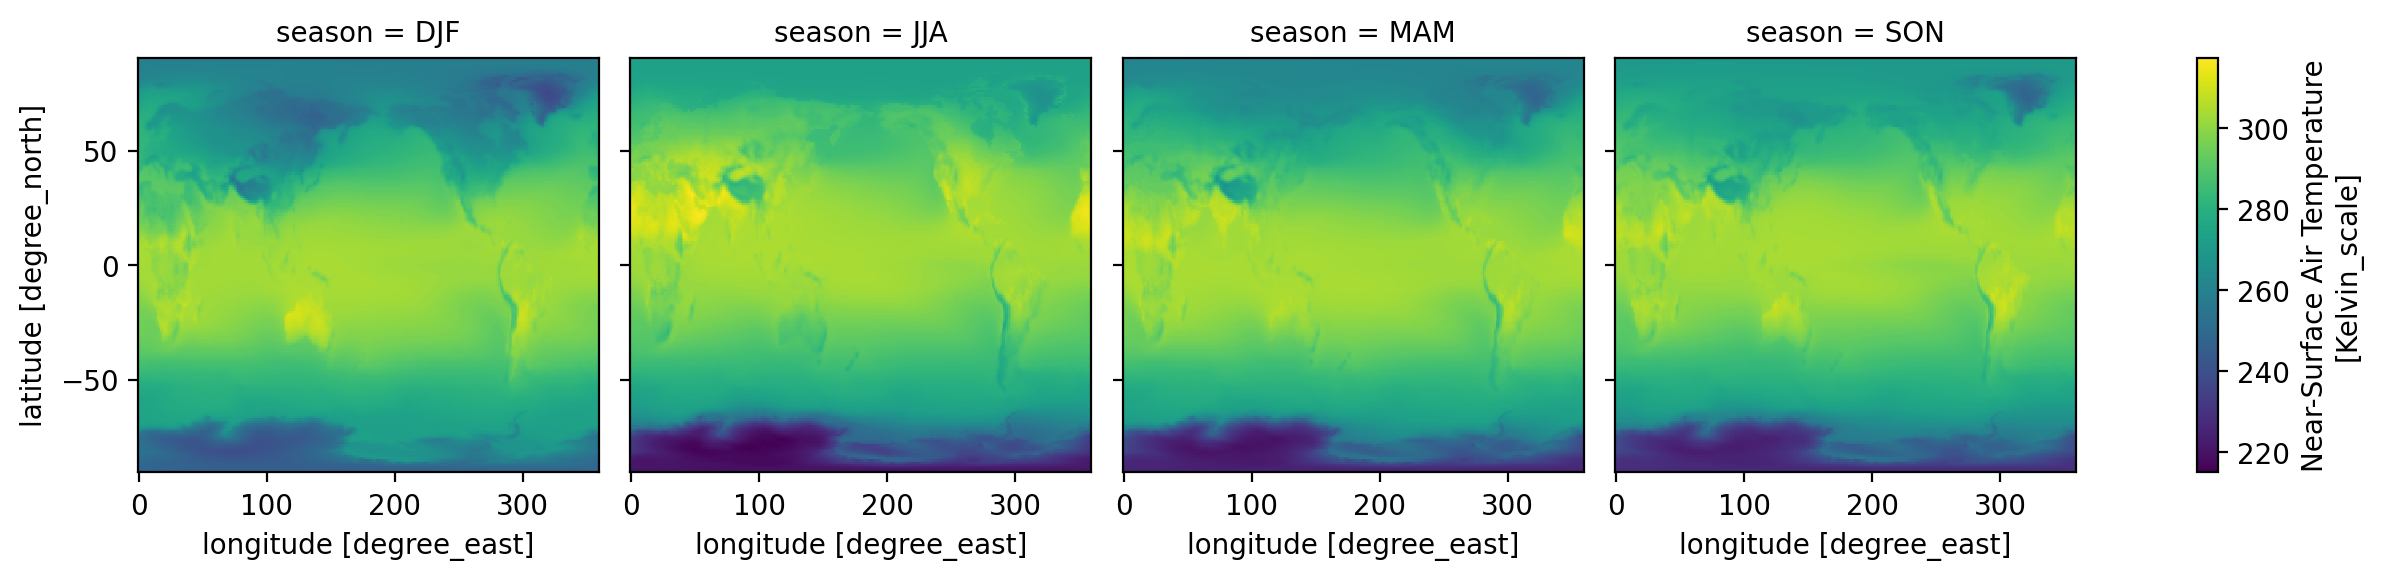

In [32]:
# Get the seasonal averages
tas.groupby("T.season").mean().plot(col="season")

#### Resample

A similar function to `groupby()` is `resample()` which is a special `groupby` for time axes. With this function, we can very easily calculate annual averages.

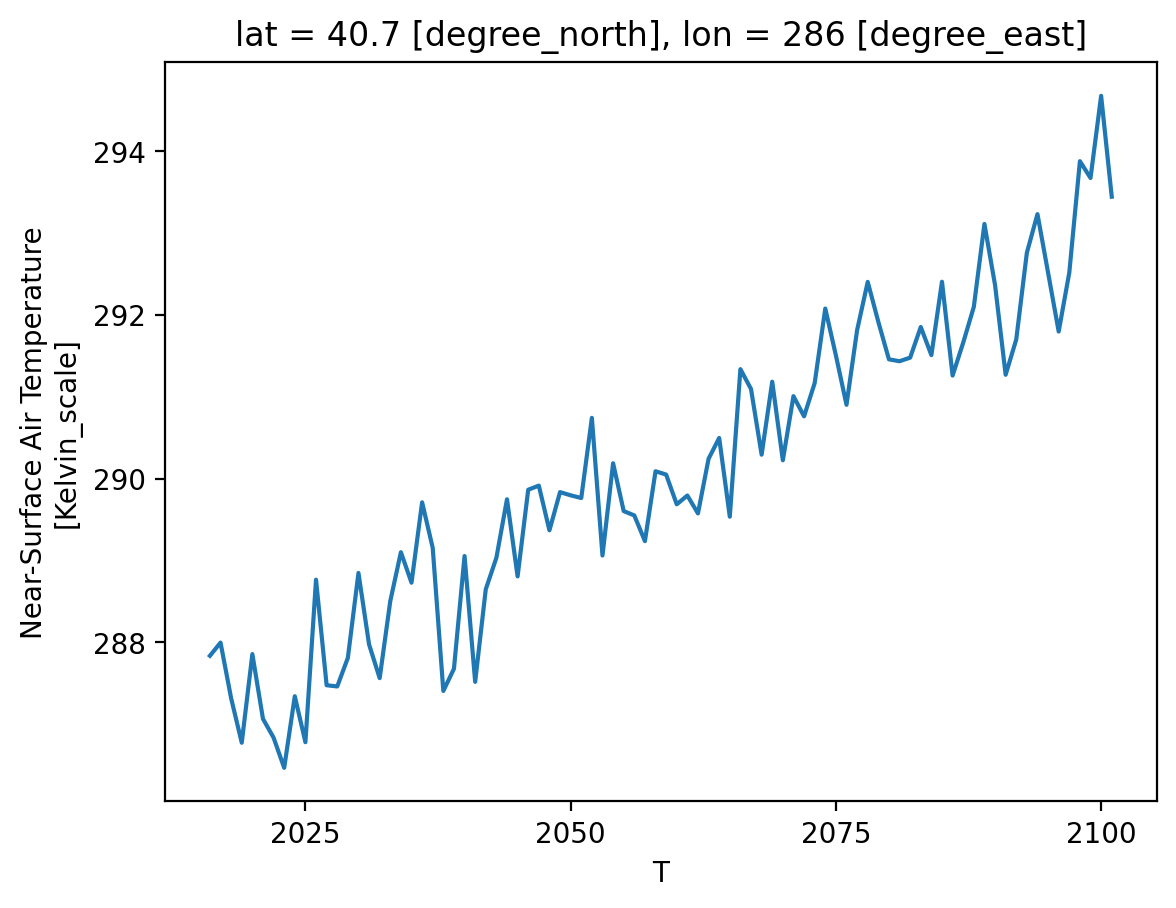

In [33]:
# Get the annual average temperature in NYC
tas_nyc.resample(T="YE").mean().plot()

#### More Types of Plots

Depending on the shape of the data, Xarray can make some pretty nice plots on its own. There are also plenty of keyword arguments.

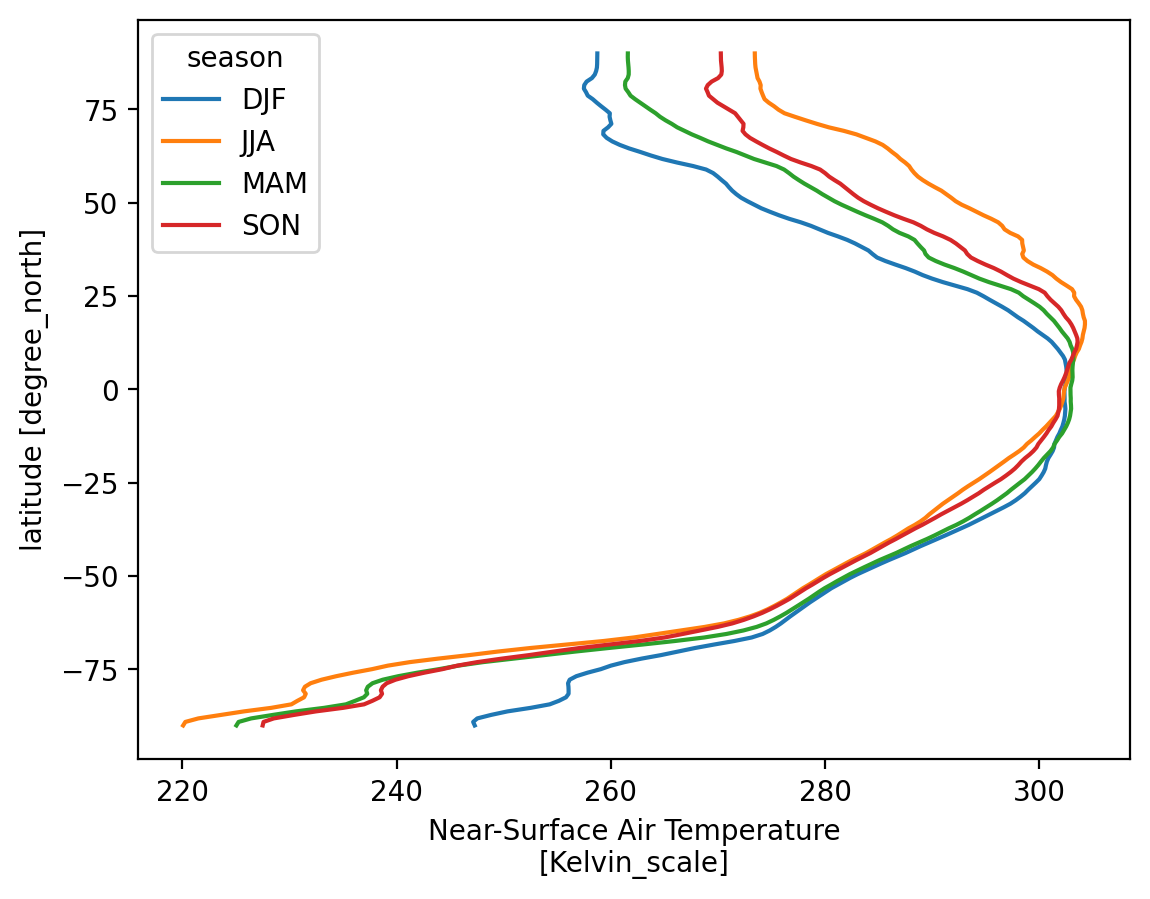

In [34]:
# Make a line plot of the zonal-average seasonal temperature
tas.groupby("T.season").mean(dim=["lon","T"]).plot.line(hue="season",y="lat")

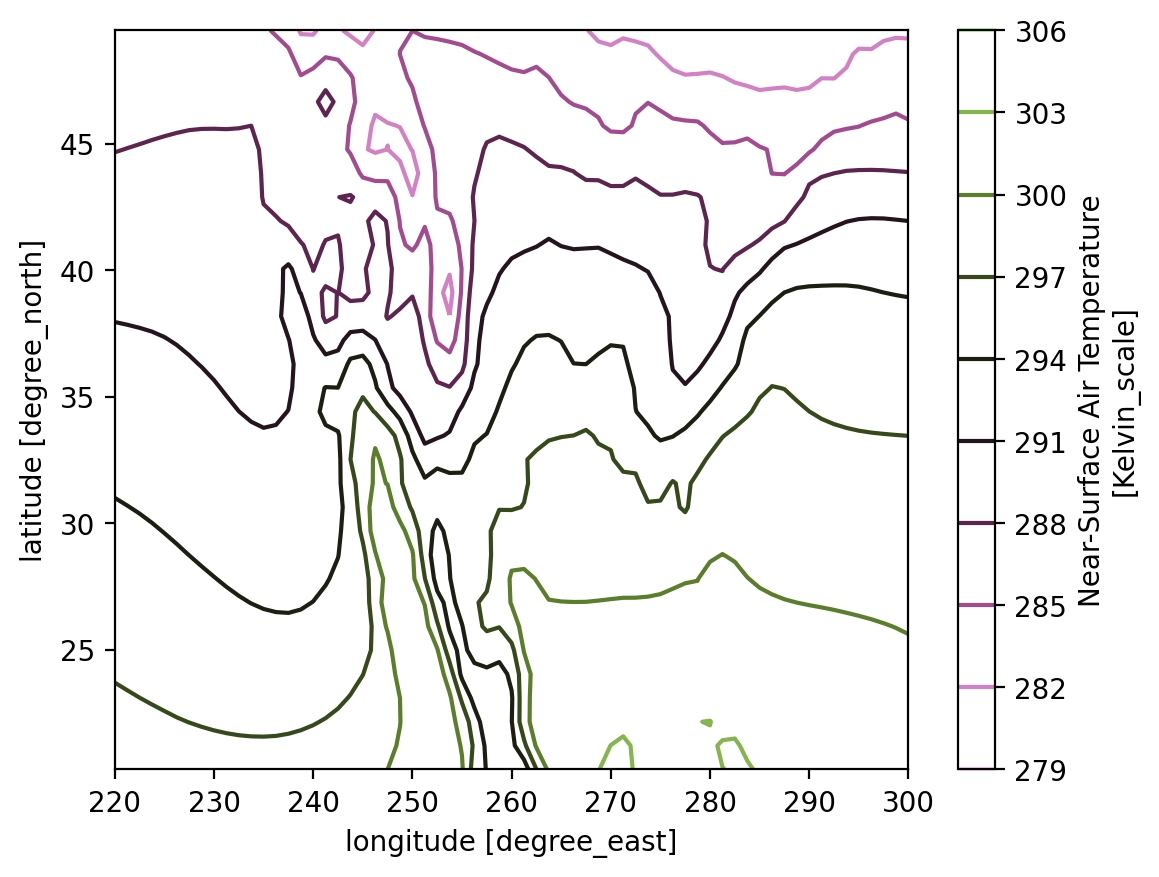

In [35]:
# Contour North America's annual average temperatures
tas.sel(lat=slice(20,50),lon=slice(220,300)).mean(dim="T").plot.contour(levels=10,cmap="vanimo",add_colorbar=True)

### Reading and Writing Xarray Datasets/DataArrays

Not all data you will encounter will be in a nice netCDF file pre-labeled for you, but that doesn't stop Xarray from being useful. Let's generate some data and create a DataArray.

In [36]:
# Generate random data
data = 100 * np.random.randn(100,100)

# Try casting it into a DataArray
xr.DataArray(data)

<xarray.DataArray (dim_0: 100, dim_1: 100)> Size: 80kB
array([[ 1.96175566e+02,  7.77327873e+01,  4.96252643e+01, ...,
        -7.94955090e+00, -4.82623314e+01, -1.23946390e+02],
       [-3.46110247e+01, -2.53245818e+00, -3.01990955e+01, ...,
         7.44112732e+01,  2.42871693e+02,  4.52329574e+01],
       [-6.05298704e+01, -1.02928304e+02, -3.24934931e+01, ...,
         1.25531582e+01, -1.00835453e-01, -1.92960213e+01],
       ...,
       [-5.79037077e+01, -1.29549977e+02,  1.40129092e+02, ...,
         2.85683219e+02, -1.66218505e+02,  7.36663997e+01],
       [-2.33962268e+02,  1.76412590e+02, -7.70264364e+01, ...,
        -5.52045951e+01,  4.46887965e+01,  8.03854520e+01],
       [ 3.44562611e+01, -6.52091098e+01, -4.12123185e+01, ...,
         8.49130298e+01,  3.39021380e+01,  7.83983190e+01]],
      shape=(100, 100))
Dimensions without coordinates: dim_0, dim_1

There are no dimension names, but we can fix that by providing them explicitly.

In [37]:
xr.DataArray(data,dims=["lat","lon"])

<xarray.DataArray (lat: 100, lon: 100)> Size: 80kB
array([[ 1.96175566e+02,  7.77327873e+01,  4.96252643e+01, ...,
        -7.94955090e+00, -4.82623314e+01, -1.23946390e+02],
       [-3.46110247e+01, -2.53245818e+00, -3.01990955e+01, ...,
         7.44112732e+01,  2.42871693e+02,  4.52329574e+01],
       [-6.05298704e+01, -1.02928304e+02, -3.24934931e+01, ...,
         1.25531582e+01, -1.00835453e-01, -1.92960213e+01],
       ...,
       [-5.79037077e+01, -1.29549977e+02,  1.40129092e+02, ...,
         2.85683219e+02, -1.66218505e+02,  7.36663997e+01],
       [-2.33962268e+02,  1.76412590e+02, -7.70264364e+01, ...,
        -5.52045951e+01,  4.46887965e+01,  8.03854520e+01],
       [ 3.44562611e+01, -6.52091098e+01, -4.12123185e+01, ...,
         8.49130298e+01,  3.39021380e+01,  7.83983190e+01]],
      shape=(100, 100))
Dimensions without coordinates: lat, lon

Next step, let's actually try adding coordinate variables. This will be make-believe latitude and longitudes.

In [38]:
# Create latitude and longitude numpy arrays
lat = np.linspace(-90,90,100)
lon = np.linspace(0,360,100)

# Try making a DataArray now
our_da = xr.DataArray(data,dims=["lat","lon"],coords=[lat,lon])
our_da

<xarray.DataArray (lat: 100, lon: 100)> Size: 80kB
array([[ 1.96175566e+02,  7.77327873e+01,  4.96252643e+01, ...,
        -7.94955090e+00, -4.82623314e+01, -1.23946390e+02],
       [-3.46110247e+01, -2.53245818e+00, -3.01990955e+01, ...,
         7.44112732e+01,  2.42871693e+02,  4.52329574e+01],
       [-6.05298704e+01, -1.02928304e+02, -3.24934931e+01, ...,
         1.25531582e+01, -1.00835453e-01, -1.92960213e+01],
       ...,
       [-5.79037077e+01, -1.29549977e+02,  1.40129092e+02, ...,
         2.85683219e+02, -1.66218505e+02,  7.36663997e+01],
       [-2.33962268e+02,  1.76412590e+02, -7.70264364e+01, ...,
        -5.52045951e+01,  4.46887965e+01,  8.03854520e+01],
       [ 3.44562611e+01, -6.52091098e+01, -4.12123185e+01, ...,
         8.49130298e+01,  3.39021380e+01,  7.83983190e+01]],
      shape=(100, 100))
Coordinates:
  * lat      (lat) float64 800B -90.0 -88.18 -86.36 -84.55 ... 86.36 88.18 90.0
  * lon      (lon) float64 800B 0.0 3.636 7.273 10.91 ... 352.7 356.4 360.0

We can add useful attributes, too.

In [39]:
our_da.lat.attrs["units"] = "degree_north"
our_da.lon.attrs["units"] = "degree_east"

our_da.lat

<xarray.DataArray 'lat' (lat: 100)> Size: 800B
array([-90.      , -88.181818, -86.363636, -84.545455, -82.727273, -80.909091,
       -79.090909, -77.272727, -75.454545, -73.636364, -71.818182, -70.      ,
       -68.181818, -66.363636, -64.545455, -62.727273, -60.909091, -59.090909,
       -57.272727, -55.454545, -53.636364, -51.818182, -50.      , -48.181818,
       -46.363636, -44.545455, -42.727273, -40.909091, -39.090909, -37.272727,
       -35.454545, -33.636364, -31.818182, -30.      , -28.181818, -26.363636,
       -24.545455, -22.727273, -20.909091, -19.090909, -17.272727, -15.454545,
       -13.636364, -11.818182, -10.      ,  -8.181818,  -6.363636,  -4.545455,
        -2.727273,  -0.909091,   0.909091,   2.727273,   4.545455,   6.363636,
         8.181818,  10.      ,  11.818182,  13.636364,  15.454545,  17.272727,
        19.090909,  20.909091,  22.727273,  24.545455,  26.363636,  28.181818,
        30.      ,  31.818182,  33.636364,  35.454545,  37.272727,  39.090909,
        40.909091,  42.727273,  44.545455,  46.363636,  48.181818,  50.      ,
        51.818182,  53.636364,  55.454545,  57.272727,  59.090909,  60.909091,
        62.727273,  64.545455,  66.363636,  68.181818,  70.      ,  71.818182,
        73.636364,  75.454545,  77.272727,  79.090909,  80.909091,  82.727273,
        84.545455,  86.363636,  88.181818,  90.      ])
Coordinates:
  * lat      (lat) float64 800B -90.0 -88.18 -86.36 -84.55 ... 86.36 88.18 90.0
Attributes:
    units:    degree_north

What about a Dataset with multiple DataArrays? We can use `xr.merge()` to put DataArrays together.

In [40]:
# make a new DataArray
data2 = 100 * np.random.randn(100,100)
our_other_da = xr.DataArray(data2,dims=["lat","lon"],coords=[lat,lon])

# Name our DataArrays! Important!
our_da = our_da.rename("dummy_var_1")
our_other_da = our_other_da.rename("dummy_var_2")

# Combine into one Dataset
our_ds = xr.merge([our_da,our_other_da])
our_ds

<xarray.Dataset> Size: 162kB
Dimensions:      (lat: 100, lon: 100)
Coordinates:
  * lat          (lat) float64 800B -90.0 -88.18 -86.36 ... 86.36 88.18 90.0
  * lon          (lon) float64 800B 0.0 3.636 7.273 10.91 ... 352.7 356.4 360.0
Data variables:
    dummy_var_1  (lat, lon) float64 80kB 196.2 77.73 49.63 ... 84.91 33.9 78.4
    dummy_var_2  (lat, lon) float64 80kB -16.81 128.9 1.646 ... 42.03 -2.84

What if we wanted to save or publish this data? We can easily save it as a netCDF file.

In [41]:
our_ds.to_netcdf("dummy_netcdf.nc")

### Xarray Exercise

Let's look at the climatology of the surface air temperature in Brisbane, Australia. Produce a time series with month on the x-axis and surface air temperature in °C on the y-axis.

1. Convert the temperature to °C and *fix the units attribute*.
2. Select the point closest to Brisbane, Australia (27.5°S, 153.0°E).
3. Using `groupby()`, create the monthly climatology of the surface air temperature.
4. Plot it using Xarray's `plot()` function.

*Hints:*
- To convert K → °C, subtract 273.15: `tas_c = tas - 273.15`. Then update the units attribute: `tas_c.attrs["units"] = "°C"`.
- Brisbane is at **27.5°S** — southern latitudes are **negative** in this dataset. Longitude is 153.0°E.
- `groupby("T.month").mean("T")` groups by month number (1–12) and averages over all years.

In [ ]:
# Convert to C

# Get data for Brisbane

# Create monthly climatology

# Plot

## Plotting Geospatial Data with Cartopy

![image.png](https://scitools.org.uk/cartopy/docs/v0.16/_static/cartopy.png)

### Introduction

We've already seen how we can create nice plots with Xarray alone. However, we need something more robust to put the data *on a map*, making sure that our data is being represented accurately on latitude/longitude grids.

We will learn about two Python libraries for plotting data. The first library is **Cartopy** (Cartography Python), which is more widely used than the other library we will discuss, **PyGMT**. Each has their advantages and the choice of which to use is entirely up to you.

Sources for this section:
- [Ryan Abernathey's Cartopy Lecture](https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html)
- [Project Pythia Introduction to Cartopy Cookbook](https://foundations.projectpythia.org/core/cartopy/cartopy/)
- [Using Cartopy with Matplotlib](https://cartopy.readthedocs.io/stable/matplotlib/intro.html)

In [42]:
# We have to start by importing Cartopy :)
# Rarely do we have to import ALL of Cartopy, just some specific submodules

import cartopy.crs as ccrs  # coordinate reference system
import cartopy.feature as cfeature  # Cartopy's feature library (boundaries, etc.)


Let's check out some of the projections available to us by typing `ccrs.` and hitting tab.

In [43]:
# ccrs.

And look at one projection.

In [44]:
ccrs.PlateCarree?

Init signature: ccrs.PlateCarree(central_longitude=0.0, globe=None)
Docstring:     
The abstract class which denotes cylindrical projections where we
want to allow x values to wrap around.
Init docstring:
Parameters
----------
proj4_params: iterable of key-value pairs
    The proj4 parameters required to define the
    desired CRS.  The parameters should not describe
    the desired elliptic model, instead create an
    appropriate Globe instance. The ``proj4_params``
    parameters will override any parameters that the
    Globe defines.
globe: :class:`~cartopy.crs.Globe` instance, optional
    If omitted, the default Globe instance will be created.
    See :class:`~cartopy.crs.Globe` for details.
File:           ~/miniforge3/envs/susc/lib/python3.14/site-packages/cartopy/crs.py
Type:           ABCMeta
Subclasses:     

We can call it to see what the map looks like by default with no data.

In [45]:
ccrs.PlateCarree()

<Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (unknown)
- N[north]: Northing (unknown)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Equidistant Cylindrical
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [46]:
ccrs.EckertIV()

<Projected CRS: +proj=eck4 +a=6378137.0 +lon_0=0 +no_defs +type=cr ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Eckert IV
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [48]:
ccrs.SouthPolarStereo()

<Projected CRS: +proj=stere +ellps=WGS84 +lat_0=-90 +lon_0=0.0 +x_ ...>
Name: unknown
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Polar Stereographic (variant A)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### GeoAxes 

Cartopy’s main draw is how well it interacts with Matplotlib. If you remember from
previous lectures, when you create a plot in Matplotlib, you produce an Axes (or AxesSubplot)
object. Cartopy overrides this to produce an instance of its own axes class, called GeoAxes.
Let’s start by making a matplotlib figure with some coastlines. Note that we will call the Matplotlib
axes method with the “projection” argument. This tells Matplotlib we are going to be creating a Cartopy GeoAxes object. Let’s make a figure with the Mollweide projection.

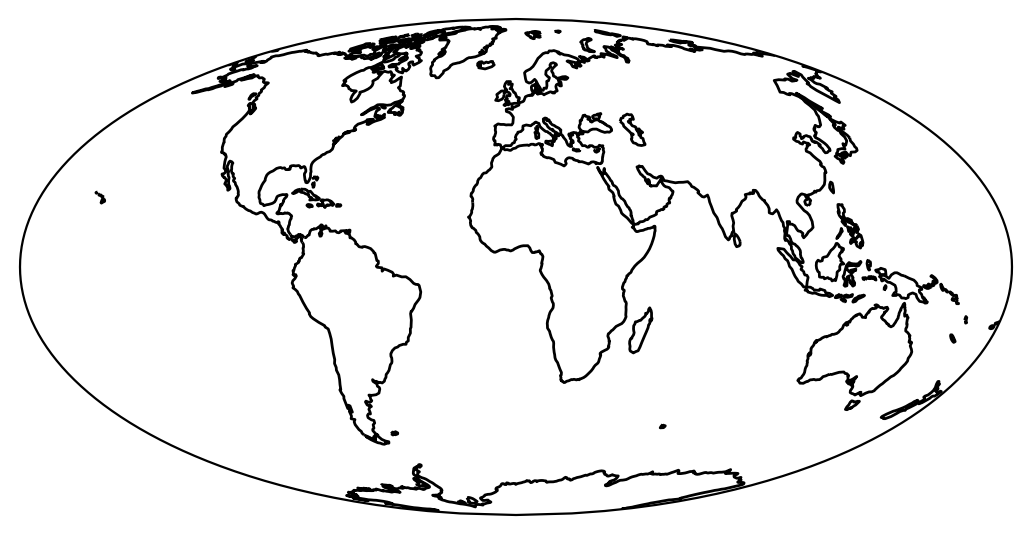

In [49]:
fig = plt.figure() # make a new figure
ax = plt.axes(projection=ccrs.Mollweide()) # create a new GeoAxes instance
ax.coastlines() # plot the coastlines

GeoAxes contains many helpful [functions](https://cartopy.readthedocs.io/stable/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html), including many similar to the plotting functions of a Matplotlib Axes instance. We already used `coastlines()`, but let's try a few more.

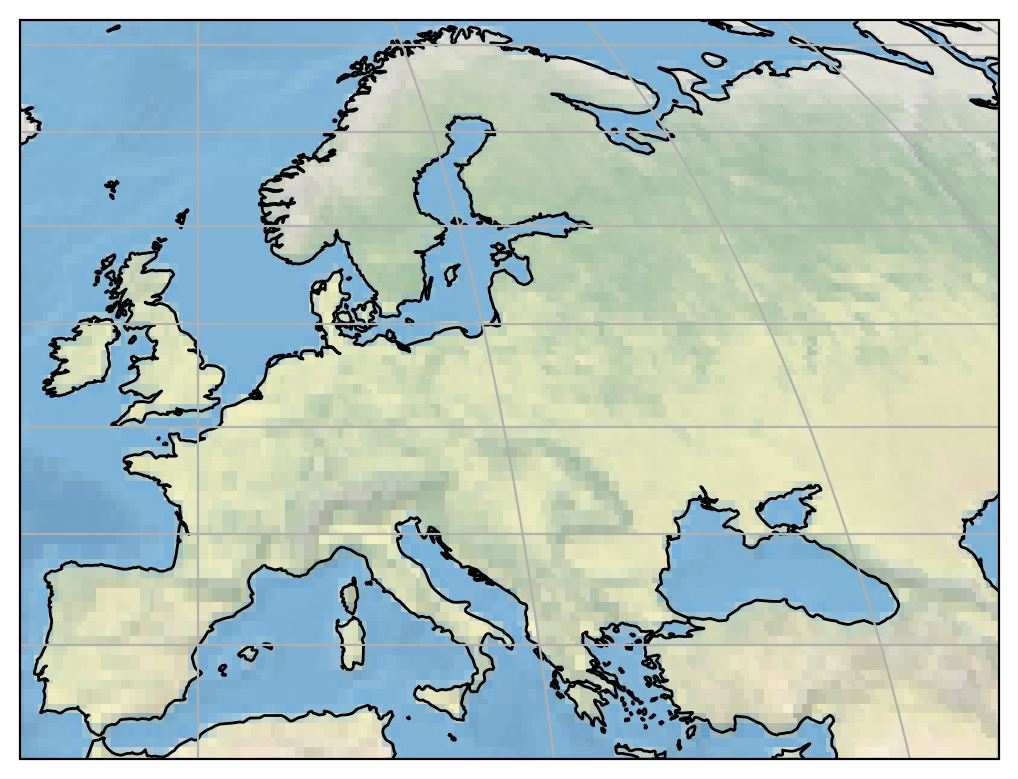

In [50]:
fig = plt.figure() # make a new figure
ax = plt.axes(projection=ccrs.Mollweide()) # create a new GeoAxes instance

ax.coastlines() # plot the coastlines
ax.stock_img() # Add a land/sea color background
ax.gridlines() # Add gridlines

# Specify the lat/lon box to display in the plot
ax.set_extent([-10,45,35,70]) # Zoom in on Europe

### Features

We imported `cfeature` before because it is the submodule that lets us access some Natural Earth datasets containing "features" like political boundaries. Let's add a few features to our plot.

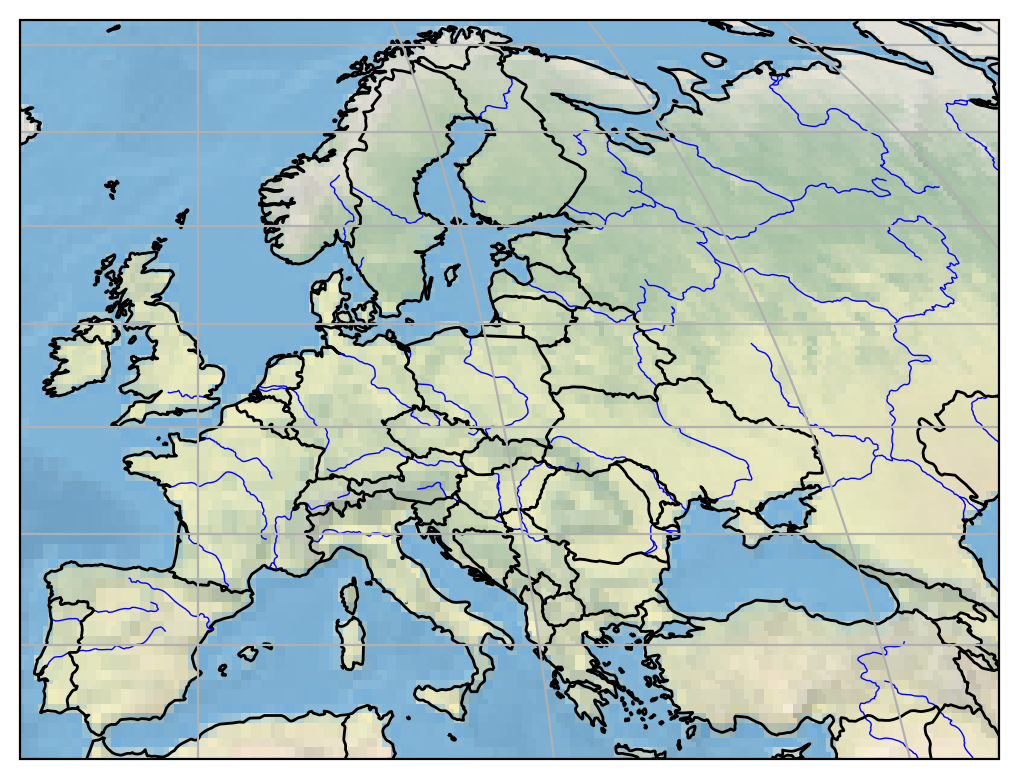

In [52]:
fig = plt.figure() # make a new figure
ax = plt.axes(projection=ccrs.Mollweide()) # create a new GeoAxes instance

ax.coastlines() # plot the coastlines
ax.stock_img() # Add a land/sea color background
ax.gridlines() # Add gridlines

# Specify the lat/lon box to display in the plot
ax.set_extent([-10,45,35,70]) # Zoom in on Europe

# Add political borders and rivers
ax.add_feature(cfeature.RIVERS,edgecolor="blue",linewidth=0.5)
ax.add_feature(cfeature.BORDERS)

By default, the borders and other features are pretty low-resolution. If we wanted to zoom on an individual country, we would probably want higher resolution features, which we can easily do.

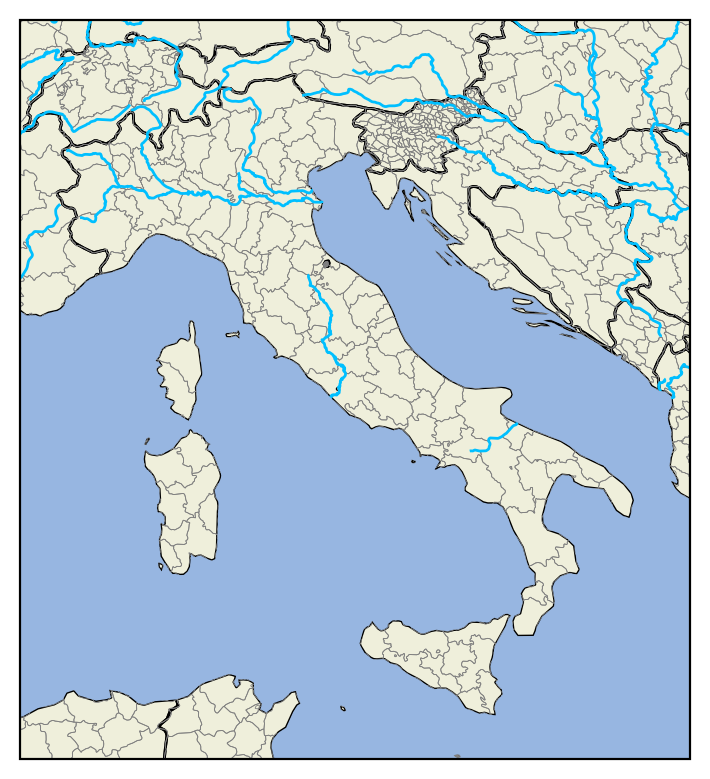

In [53]:
# Get higher resolution features
borders_50m = cfeature.NaturalEarthFeature("cultural","admin_0_countries","50m",facecolor="none")
admin1_10m = cfeature.NaturalEarthFeature("cultural","admin_1_states_provinces","10m",facecolor="none",edgecolor="gray",linewidth=0.3)
rivers_10m = cfeature.NaturalEarthFeature("physical","rivers_lake_centerlines","10m",edgecolor="deepskyblue",facecolor="none")
ocean_50m = cfeature.NaturalEarthFeature("physical","ocean","50m",edgecolor="none",facecolor=cfeature.COLORS["water"])
land_50m = cfeature.NaturalEarthFeature("physical","land","50m",edgecolor="none",facecolor=cfeature.COLORS["land"])

fig = plt.figure() # make a new figure
ax = plt.axes(projection=ccrs.Mollweide()) # create a new GeoAxes instance

# Specify the lat/lon box to display in the plot
ax.set_extent([6, 19, 36, 48]) # Zoom in on Europe

# Iterate through list of features and add them to our map
# Note: the order is IMPORTANT!
for f in [land_50m,borders_50m,admin1_10m,rivers_10m,ocean_50m]:
    ax.add_feature(f)

### Combining Data & Cartopy

#### Projection & Transform

As we start to plot data on our Cartopy GeoAxes, there are two
important keyword arguments to keep in mind: **projection** and **transform**.

We've already had practice setting the projection of the GeoAxes object we create. However, if we
want to plot data, *we need to give Cartopy more information about what our data looks like*. This
is where the transform keyword argument comes in.

Cartopy's documentation has a great [explanation](https://cartopy.readthedocs.io/stable/tutorials/understanding_transform.html). The core concept is that the projection of
your axes is independent of the coordinate system your data is defined in. The projection argument
is used when creating plots and determines the projection of the resulting plot (i.e. what the plot
looks like). The transform argument to plotting functions tells Cartopy what coordinate system
your data are defined in.

Let's show this by plotting a line between two points. On a sphere, this can be done a few ways,
including:
- as the shortest straight line on the sphere (Geodetic)
- as a straight line in projected (Cartesian) space

In [54]:
# set the lat and lons of our points
# remember, degrees west and south are negatives
# dictionaries should look familiar :)
nyc = dict(lat=40.7128,lon=-74.0060)
dubai = dict(lat=25.2048,lon=55.2708)

# make a list of the lats and lons for plotting
lats = [nyc['lat'],dubai['lat']]
lons = [nyc['lon'],dubai['lon']]


Now we will plot the points and lines on a PlateCarree projection, once specifying the transform
and once without. Note that if you do not specify the transform, Cartopy will assume the data is
formatted the same as the underlying GeoAxes object.

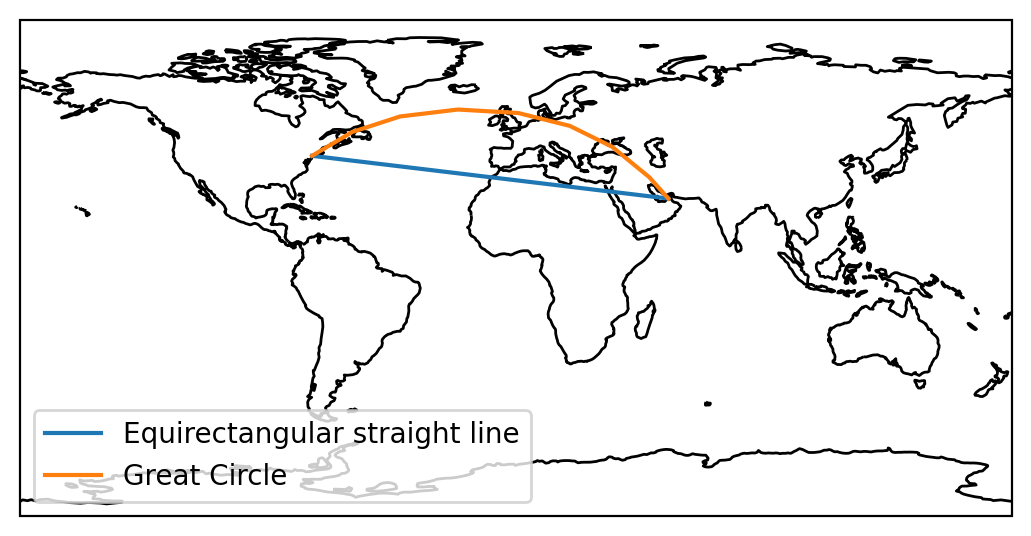

In [55]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.plot(lons, lats, label='Equirectangular straight line')
ax.plot(lons, lats, label='Great Circle', transform=ccrs.Geodetic())
ax.coastlines()
ax.legend()
ax.set_global()

As you can see, including the transform argument told Cartopy that our data is defined in the
Geodetic coordinate system, and thus we plotted our great circle line.

#### NumPy arrays with Cartopy

We will make some fake data for now to show how plotting works with basic, unlabeled NumPy arrays. Later, we will combine our model data with Xarray and Cartopy to produce plots.

In [56]:
# reminder: the linspace function makes equidistant points
lon = np.linspace(-80, 80, 25) # 80W to 80E
lat = np.linspace(30, 70, 25) # 30N to 70N
lon2d, lat2d = np.meshgrid(lon, lat) # makes 2D grid of lat/lon

# make some random data
data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)

What happens when we plot it without the transform argument?

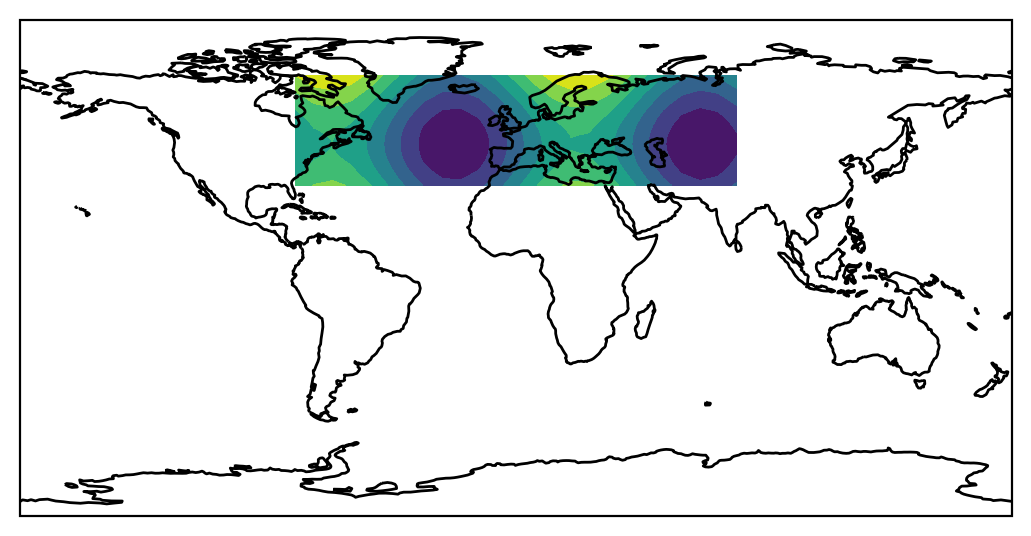

In [57]:
# The projection keyword determines how the plot will look
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global() # show the entire map
ax.coastlines() # add coastlines
ax.contourf(lon, lat, data) # didn't use transform, but looks ok...

This looks fine because we are plotting on a PlateCarree projection and our data is defined in the
same coordinate system. Even if we include the transform argument, nothing should change.

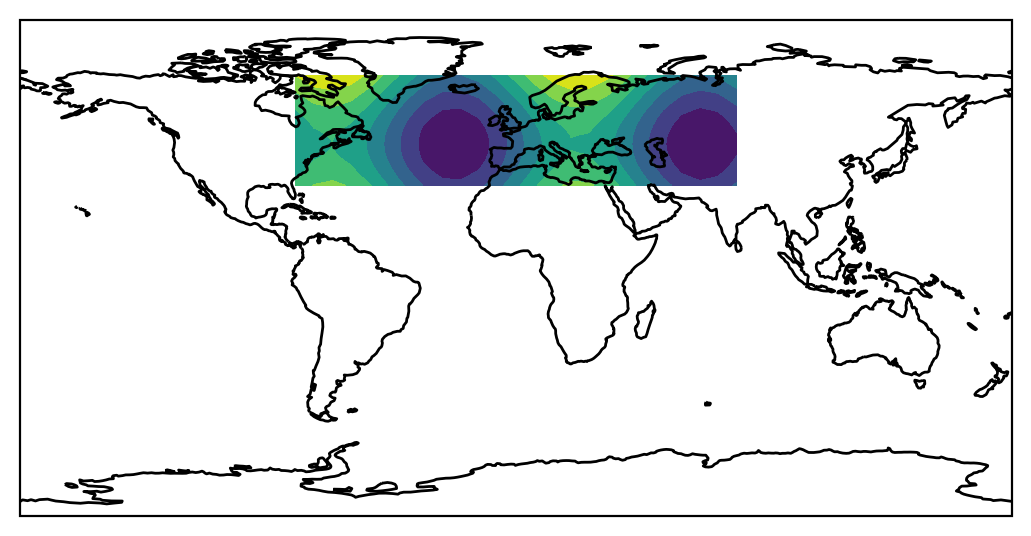

In [58]:
# The data are defined in lat/lon coordinate system, so PlateCarree()
# is the appropriate choice:
data_crs = ccrs.PlateCarree()

# The projection keyword determines how the plot will look
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()
ax.contourf(lon, lat, data, transform=data_crs)

Issues arise when we exclude the transform argument and our data and projection are not on the
same coordinate system. Look at what happens if we try plotting the data without transform on
a different projection.

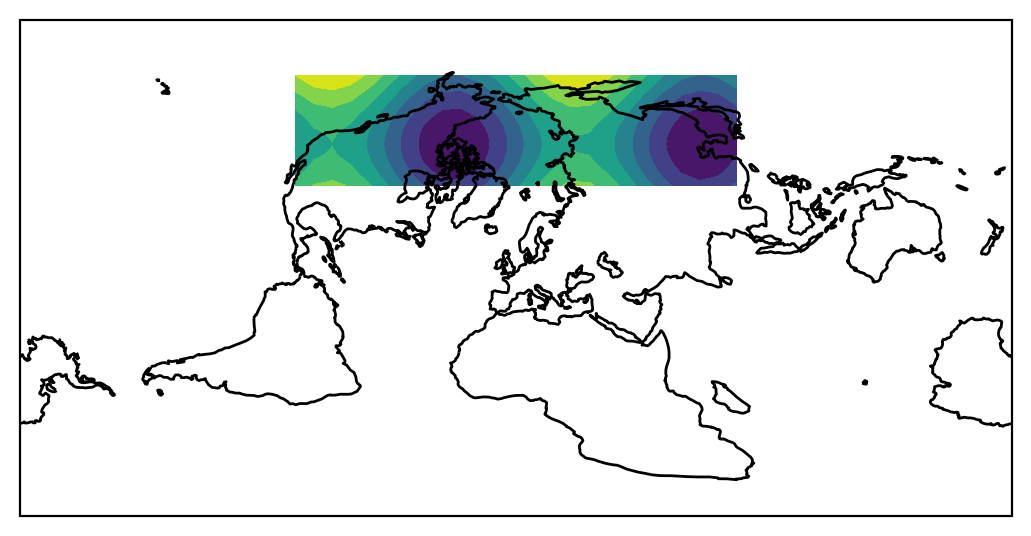

In [59]:
# Now we plot a rotated pole projection
projection = ccrs.RotatedPole(pole_longitude=-177.5, pole_latitude=37.5)
plt.figure()

ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()
ax.contourf(lon, lat, data) # didn't use transform, RIP

That’s definitely not right. Cartopy is assuming our data is on the rotated pole coordinate system
already, which is incorrect. Let’s fix it.

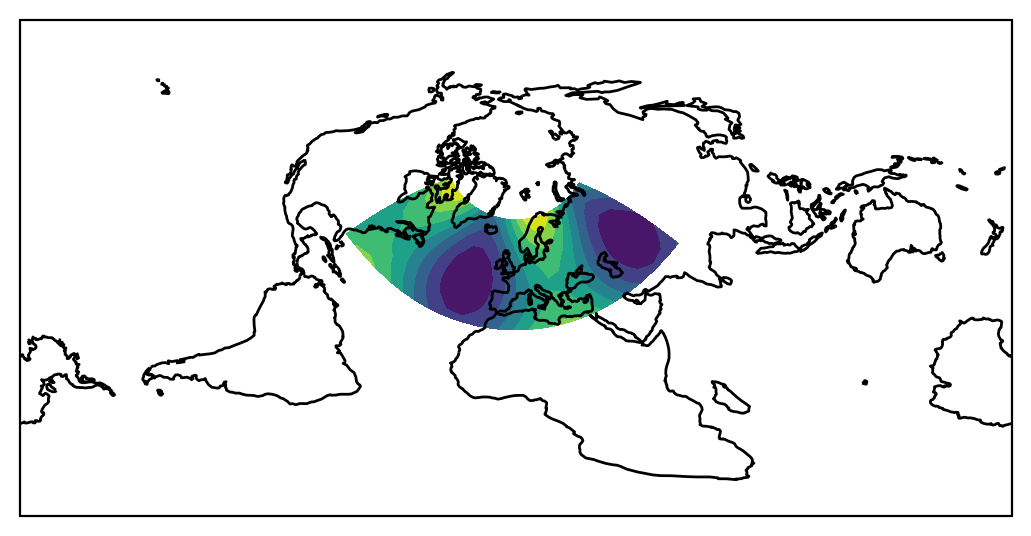

In [60]:
# A rotated pole projection again...
projection = ccrs.RotatedPole(pole_longitude=-177.5, pole_latitude=37.5)
plt.figure()

ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()

# ...but now using the transform argument
ax.contourf(lon, lat, data, transform=data_crs)

Here’s our lesson: **Always remember to include the transform and projection arguments
when plotting data with Cartopy!**

#### Xarray & Cartopy

You should already have your surface air temperature from earlier. Let's try plotting it on a map with Cartopy.


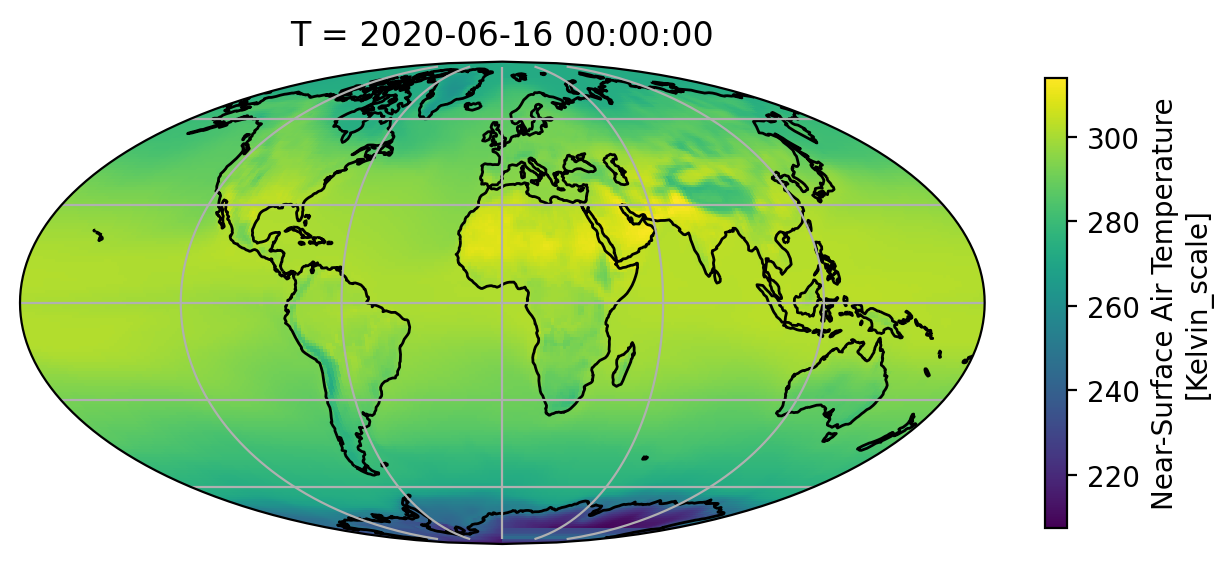

In [61]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.Mollweide()) # let's go with Mollweide

# pick some date to plot the temperature
tas.sel(T="2020-06").plot(ax=ax,
    transform=ccrs.PlateCarree(), # Notice that we can specify the transformation here
    cbar_kwargs={'shrink': 0.5}, # This is just to shrink the colorbar a bit
)

# spruce it up
ax.coastlines()
ax.gridlines()

# trim some whitespace
plt.tight_layout()

In just a few lines, we were able to create a publication-worthy plot. Cartopy and Xarray work well together.

To save a figure to disk: `plt.savefig("filename.png", dpi=300, bbox_inches="tight")`. For PyGMT figures, use `fig.savefig("filename.png")` instead.

##### Example: Plotting Surface Winds

Let's do something a bit different. Let's try looking at the annual average 10 meter winds in CONUS in a CMIP6 experiment.

In [62]:
# Set URL
url_uas = ("http://mary.ldeo.columbia.edu:81/CMIP6i/.byScenario/.ssp585/.Amon/"+
           ".uas/.GFDL-CM4/.gr1/.r1i1p1f1/.uas/dods") # URL to zonal-wind file
url_vas = url_uas.replace("uas","vas") # Replace uas with vas for meridional-wind file

# Read in the data while temporarily ignoring the time dimension
ds_uas = fix_calendar(xr.open_dataset(url_uas, decode_times=False))
ds_vas = fix_calendar(xr.open_dataset(url_vas, decode_times=False))

# Combine uas and vas into one Dataset
ds_winds = xr.merge([ds_uas,ds_vas])

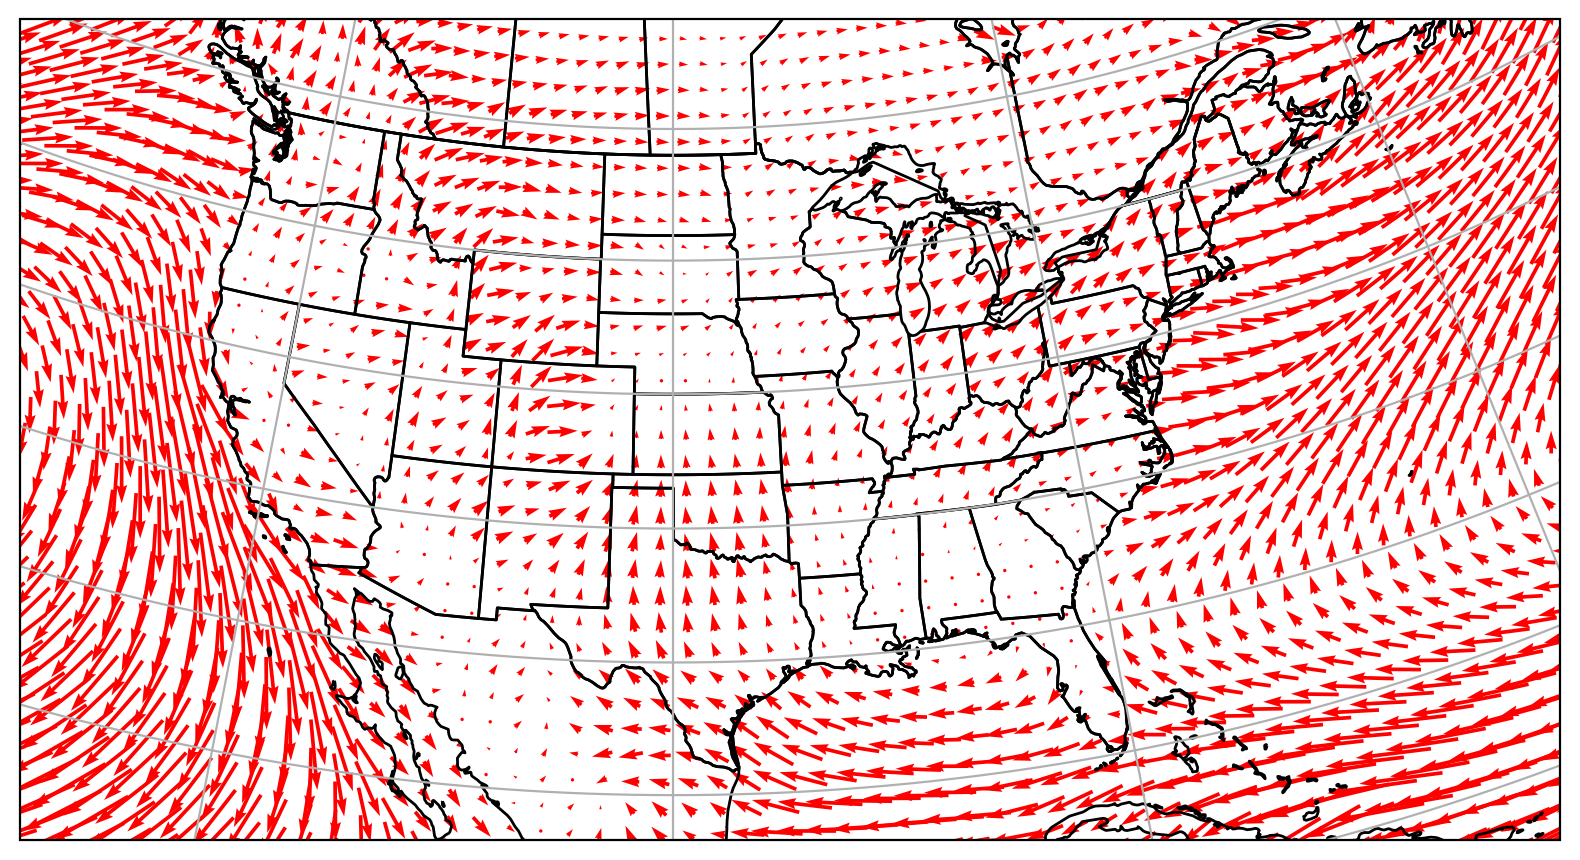

In [63]:
fig = plt.figure(figsize=(8,6))

# Specify our projection
proj = ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=40)
ax = plt.axes(projection=proj)

ds_winds.mean(dim="T").plot.quiver(x="lon",y="lat",u="uas",v="vas",transform=ccrs.PlateCarree(),ax=ax,scale=100,color="red")

ax.set_extent((-127,-63,20,50))

# spruce up the plot, this time with states and borders
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.coastlines()
ax.gridlines()

plt.tight_layout()

##### Exercise: Plotting Arctic Sea Ice

Using the sic variable defined below, create a map of the sea ice concentration in March of
1990\*. Use an orthographic projection centered on the North Pole. Add coastlines, gridlines, and
be sure to use an appropriate [colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html).


\* As a reminder, these historical model simulations do not correspond to the actual weather at the
given date. You can think of it as March 1990 in some other timeline cooked up by the model.

*Hints:*
- `ccrs.Orthographic(central_longitude=0, central_latitude=90)` centers the view on the North Pole.
- Select March 1990 with `.sel(time="1990-03")`.
- Sea ice concentration (`sic`) ranges from 0–100%. A sequential colormap like `"Blues"` or `"YlOrRd_r"` works well.

In [ ]:
url = (
    "http://esgf-node.ornl.gov/thredds/dodsC/cmip5_css02_data/cmip5/"
    "output1/CCCma/CanESM2/historical/mon/seaIce/OImon/r1i1p1/sic/1/"
    "sic_OImon_CanESM2_historical_r1i1p1_185001-200512.nc"
)
LOCAL_SIC = "sic_CanESM2_historical_r1i1p1_199003.nc"

try:
    ds = xr.open_dataset(url)
    print("Loaded from ESGF ORNL (full dataset: 1850–2005).")
except Exception as e:
    print(f"ESGF unavailable ({e})\nLoading local fallback (March 1990 only).")
    ds = xr.open_dataset(LOCAL_SIC)

ds.sic


In [ ]:
# make figure with Orthographic projection

# select and plot sic at correct date

# add coastlines and gridlines

##### Exercise: Plotting ENSO

El Niño and La Niña events are some of the most impactful climate
events on Earth. El Niños produce especially warm sea surface temperatures in the Eastern Pacific
near Peru and central Pacific, while La Niña events produce anomalously cold sea surface temperatures.

Using the dataset below, calculate the average sea surface temperature anomaly over the
period from July 2007 to June 2008. Plot it on a Mollweide projection, centered on the Pacific,
and set the extent to be from 95E to 55W and 60S to 70N. Don't forget coastlines. Based on your
plot, was the 2007-2008 event an El Niño or La Niña?

*Hint:* An **anomaly** is the departure from the long-term average. Here are the steps:
1. Compute the monthly climatology (long-term average for each month) with `sst.groupby("time.month").mean(dim="time")`.
2. Select the period of interest from `sst` using `.sel(time=slice("2007-07-01", "2008-06-01"))`.
3. Subtract the climatology from the selected period using `.groupby("time.month") - monthly_clim`, then take the time mean with `.mean(dim="time")`.
4. To center the Mollweide projection on the Pacific, use `ccrs.Mollweide(central_longitude=-160)`.
5. Don't forget to pass `transform=ccrs.PlateCarree()` when plotting.

In [ ]:
sst = xr.open_dataset("https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc").sst
sst

In [ ]:
# calculate anomaly

# make figure and Mollweide projection

# plot anomaly, set extent, add coastlines

## Alternative Mapping Library: PyGMT

<img src="https://forum.generic-mapping-tools.org/uploads/default/original/1X/3640d9ae84122cb7ffaaae64601b32777fa113de.png" alt="drawing" width="500"/>

Sources:
- [PyGMT Documentation](https://www.pygmt.org/dev/index.html)

PyGMT is a Python library for making maps and figures using the Generic Mapping Tools, a widely used command-line program in the Earth Sciences. It is a solid alternative to Cartopy for map-making. Some advantages over Cartopy are:
- Higher quality maps
- More functions for plotting geophysical data
- Full integration with Generic Mapping Tools for even more functions
- **Does not use Matplotlib!**

However, there are a few reasons why you might pick Cartopy over PyGMT:
- PyGMT has a steeper learning curve, less Pythonic
- Less flexible for general mapping purposes
- Requires Generic Mapping Tools installed
- Smaller user base

TL;DR: PyGMT is more specialized for the Earth Sciences and tends to make better maps out-of-the-box, but its specialization comes at a cost of usability and generic application.

In [64]:
# Start by importing PyGMT
import pygmt

### Shorelines

Starting easy, let's just plot shorelines.

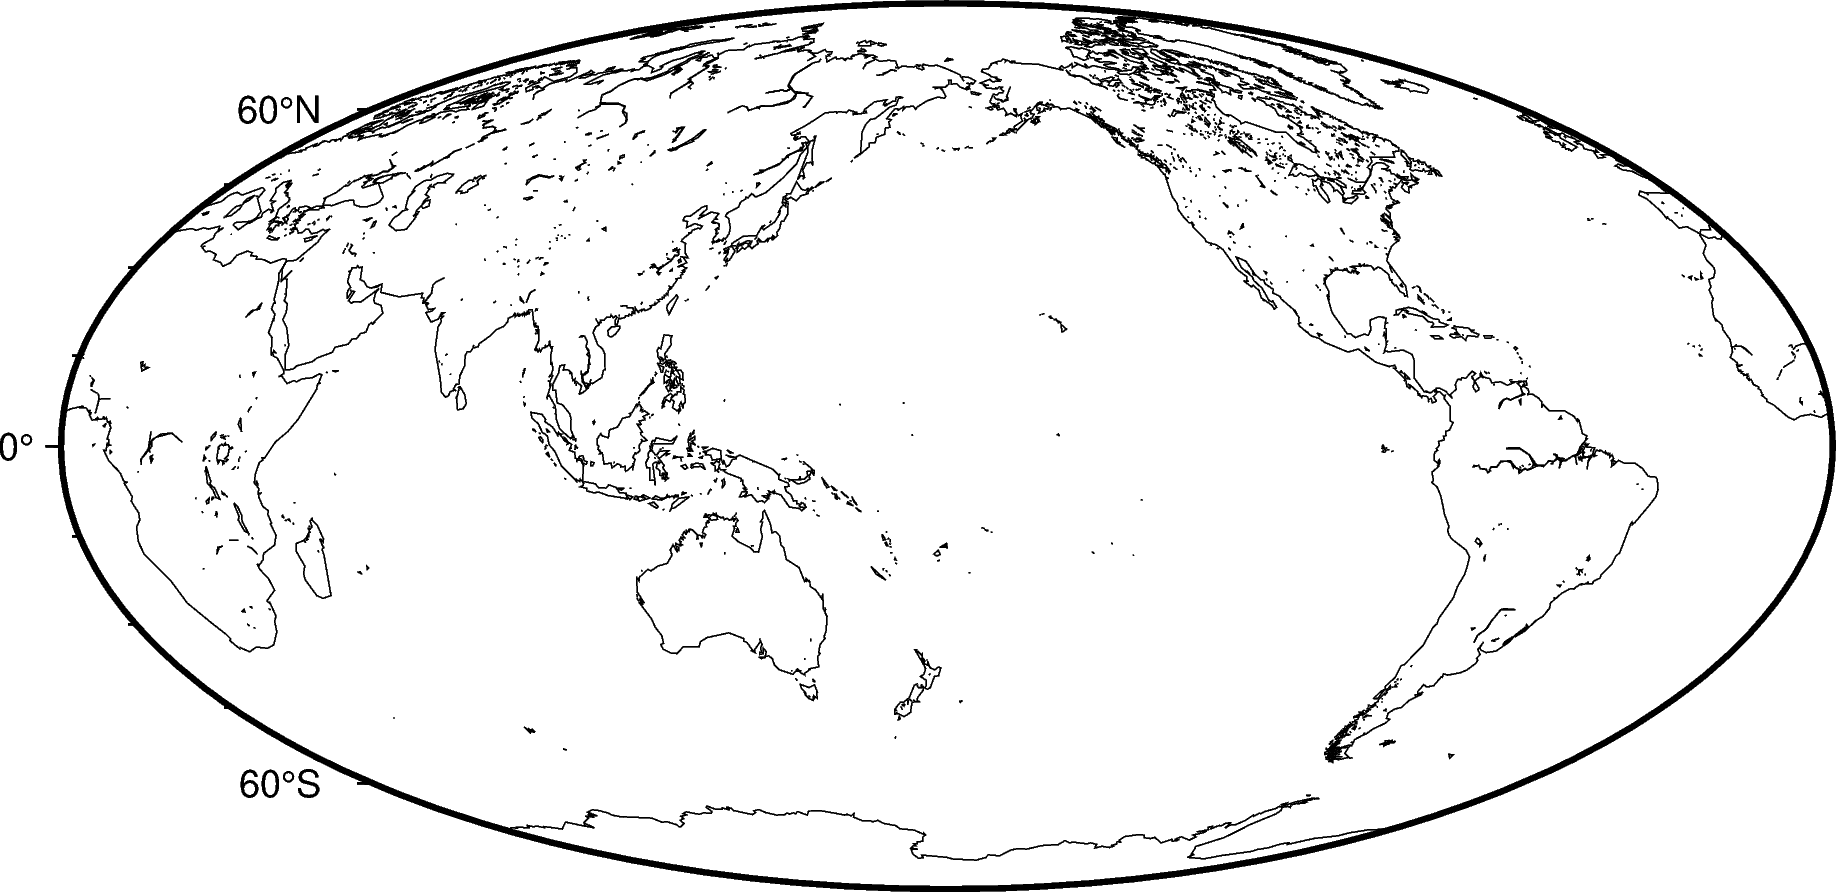

In [65]:
fig = pygmt.Figure()
# region="g"       → global extent (entire world)
# projection="W15c" → Winkel tripel projection, 15 cm wide
# frame=True        → draw the map border
fig.basemap(region="g", projection="W15c", frame=True)
fig.coast(shorelines=True) # Draw shorelines
fig.show()

Remember, PyGMT does NOT use Matplotlib. It is its own Figure object.

In [66]:
type(fig)

pygmt.figure.Figure

There are 4 levels of shorelines, ranging from coastlines to lakeshores, all the way down to lakes in islands in lakes! To only plot the coastlines, we are going to specify the shorelines argument in the `coast()` function with a "1" for only the highest level (coastlines) and the pen to draw them.

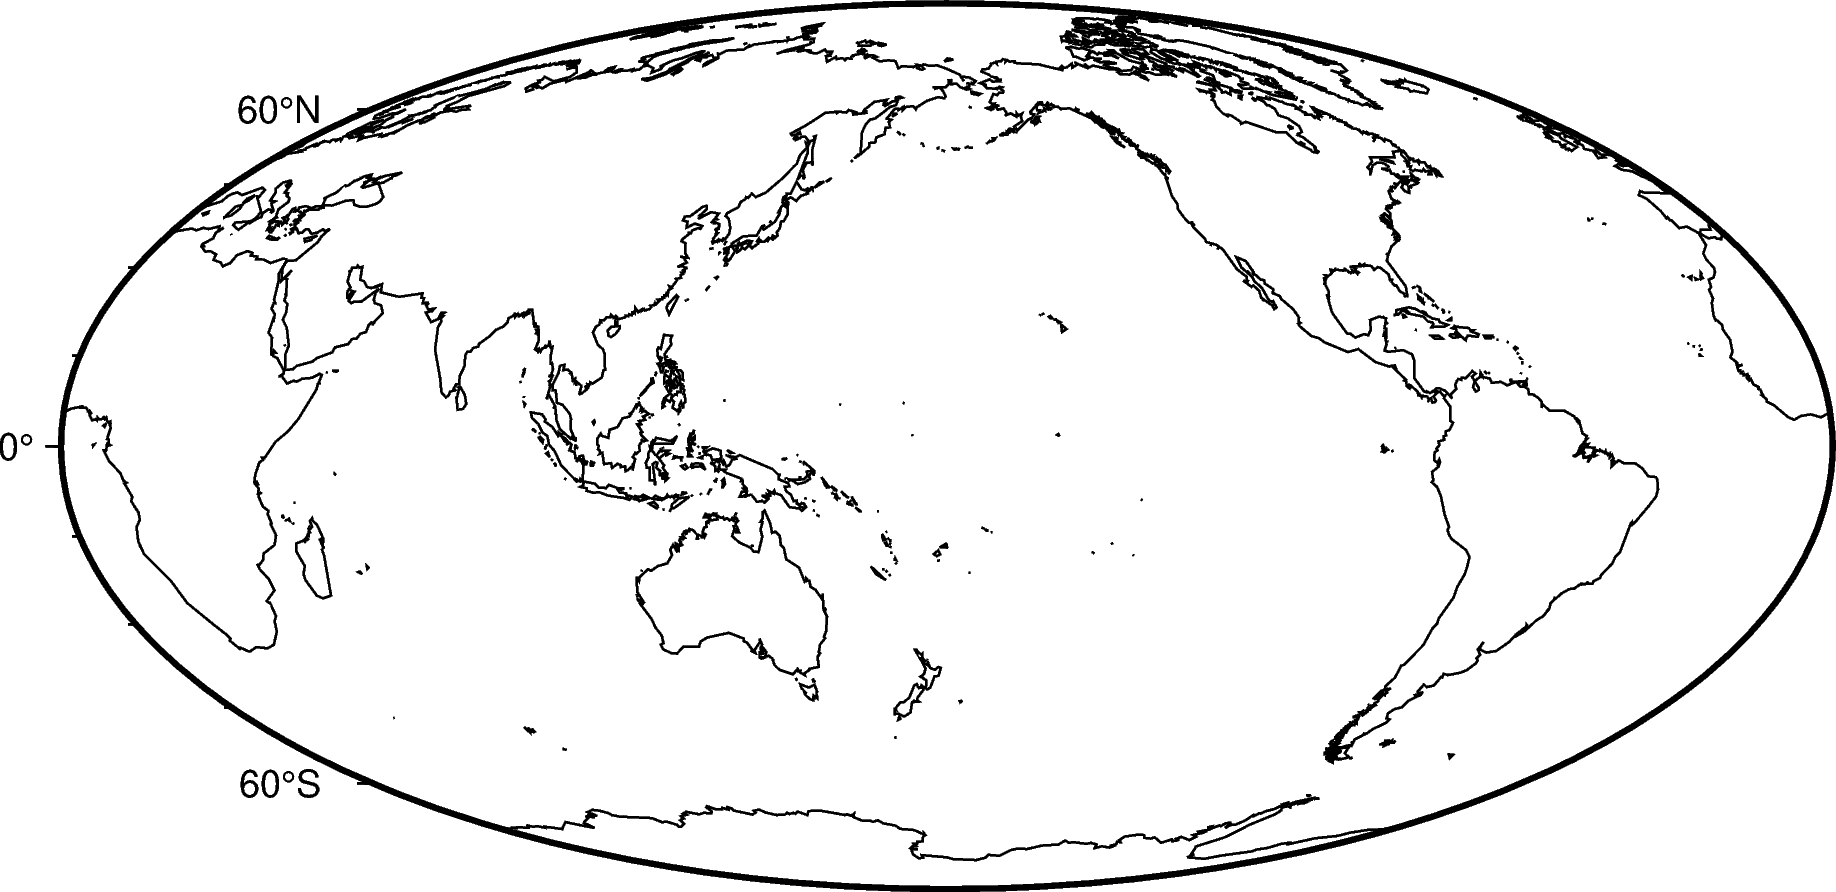

In [67]:
fig = pygmt.Figure()
fig.basemap(region="g", projection="W15c", frame=True) # btw, frame=plot outline
# Pen format for shorelines: "level/width,color" — 0.5p = 0.5 point width
fig.coast(shorelines="1/0.5p,black")
fig.show()

Let's finish off this section by adding colors for land and water.

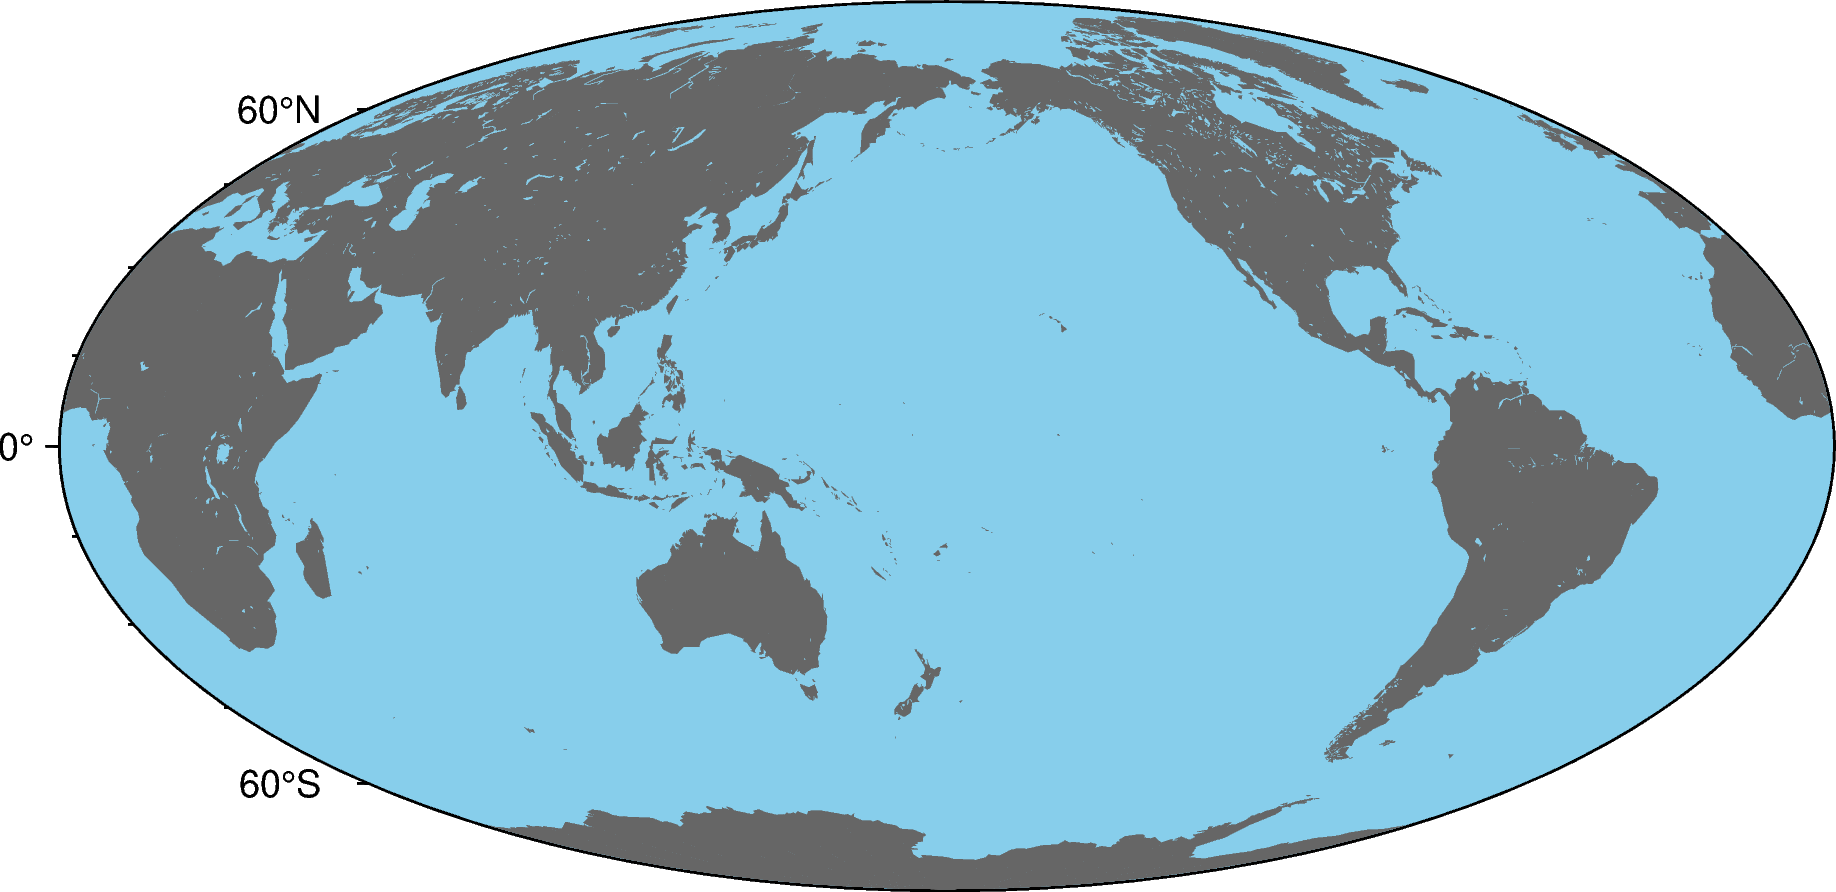

In [68]:
fig = pygmt.Figure()
fig.basemap(region="g", projection="W15c", frame=True)
fig.coast(land="#666666", water="skyblue") # Specify colors now
fig.show()

### Frames, Ticks, Titles, and Labels

Previously, we set `frame = True`, but we can actually modify the frame on our plots.

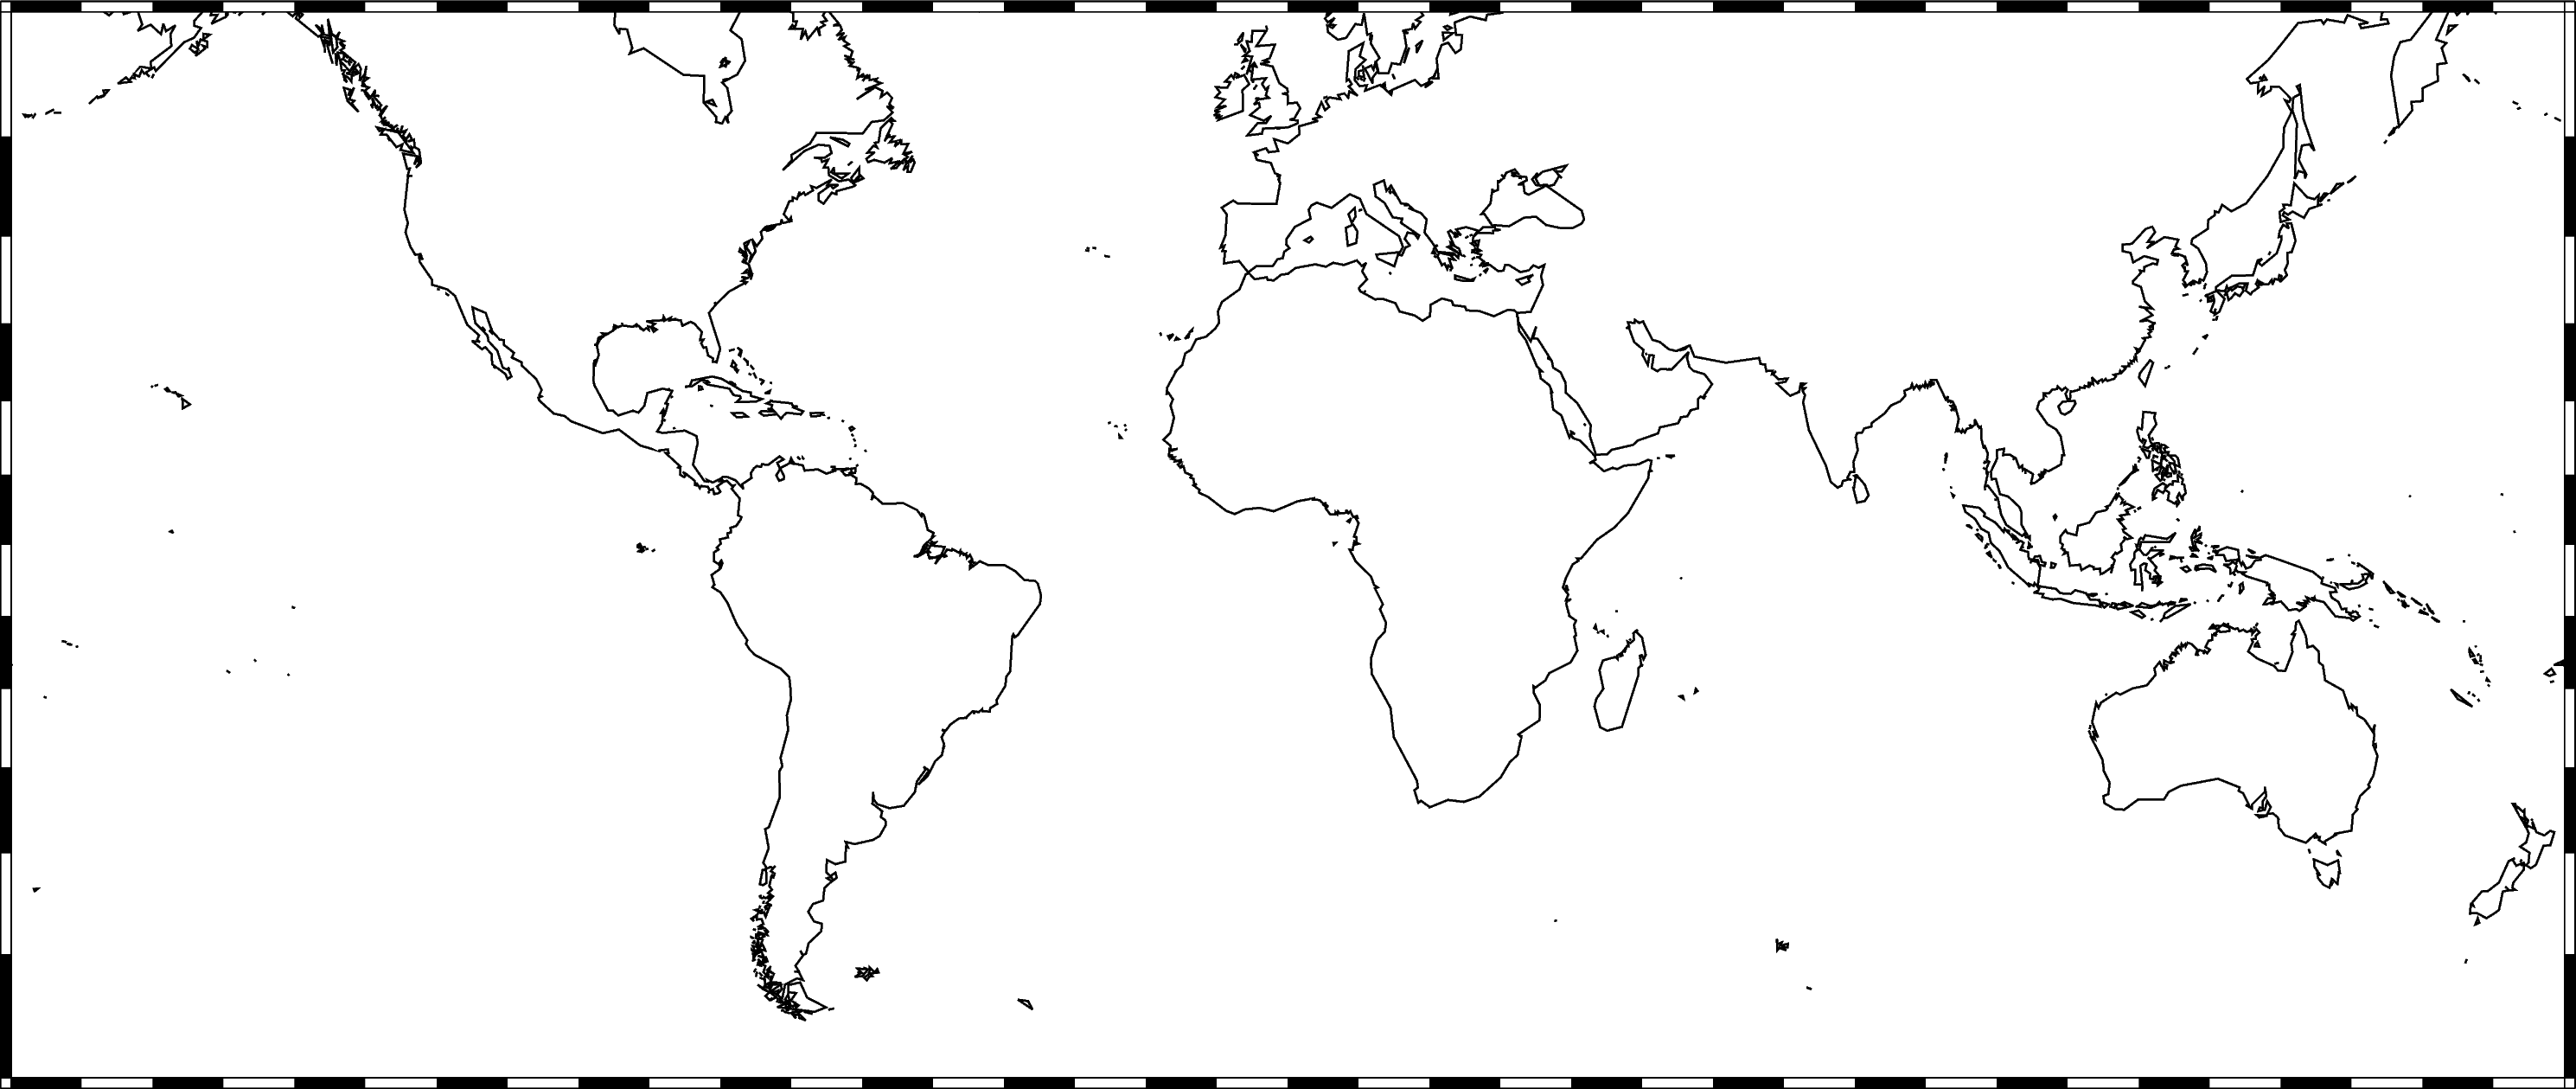

In [69]:
fig = pygmt.Figure()
fig.coast(shorelines="1/0.5p", region=[-180, 180, -60, 60], projection="M25c") # Mercator
fig.basemap(frame="f") # f = default GMT frame
fig.show(width=800) # Notice that figure width goes here

To add ticklines like we did in our previous maps, we set `frame` to either `True` or `"af"`.

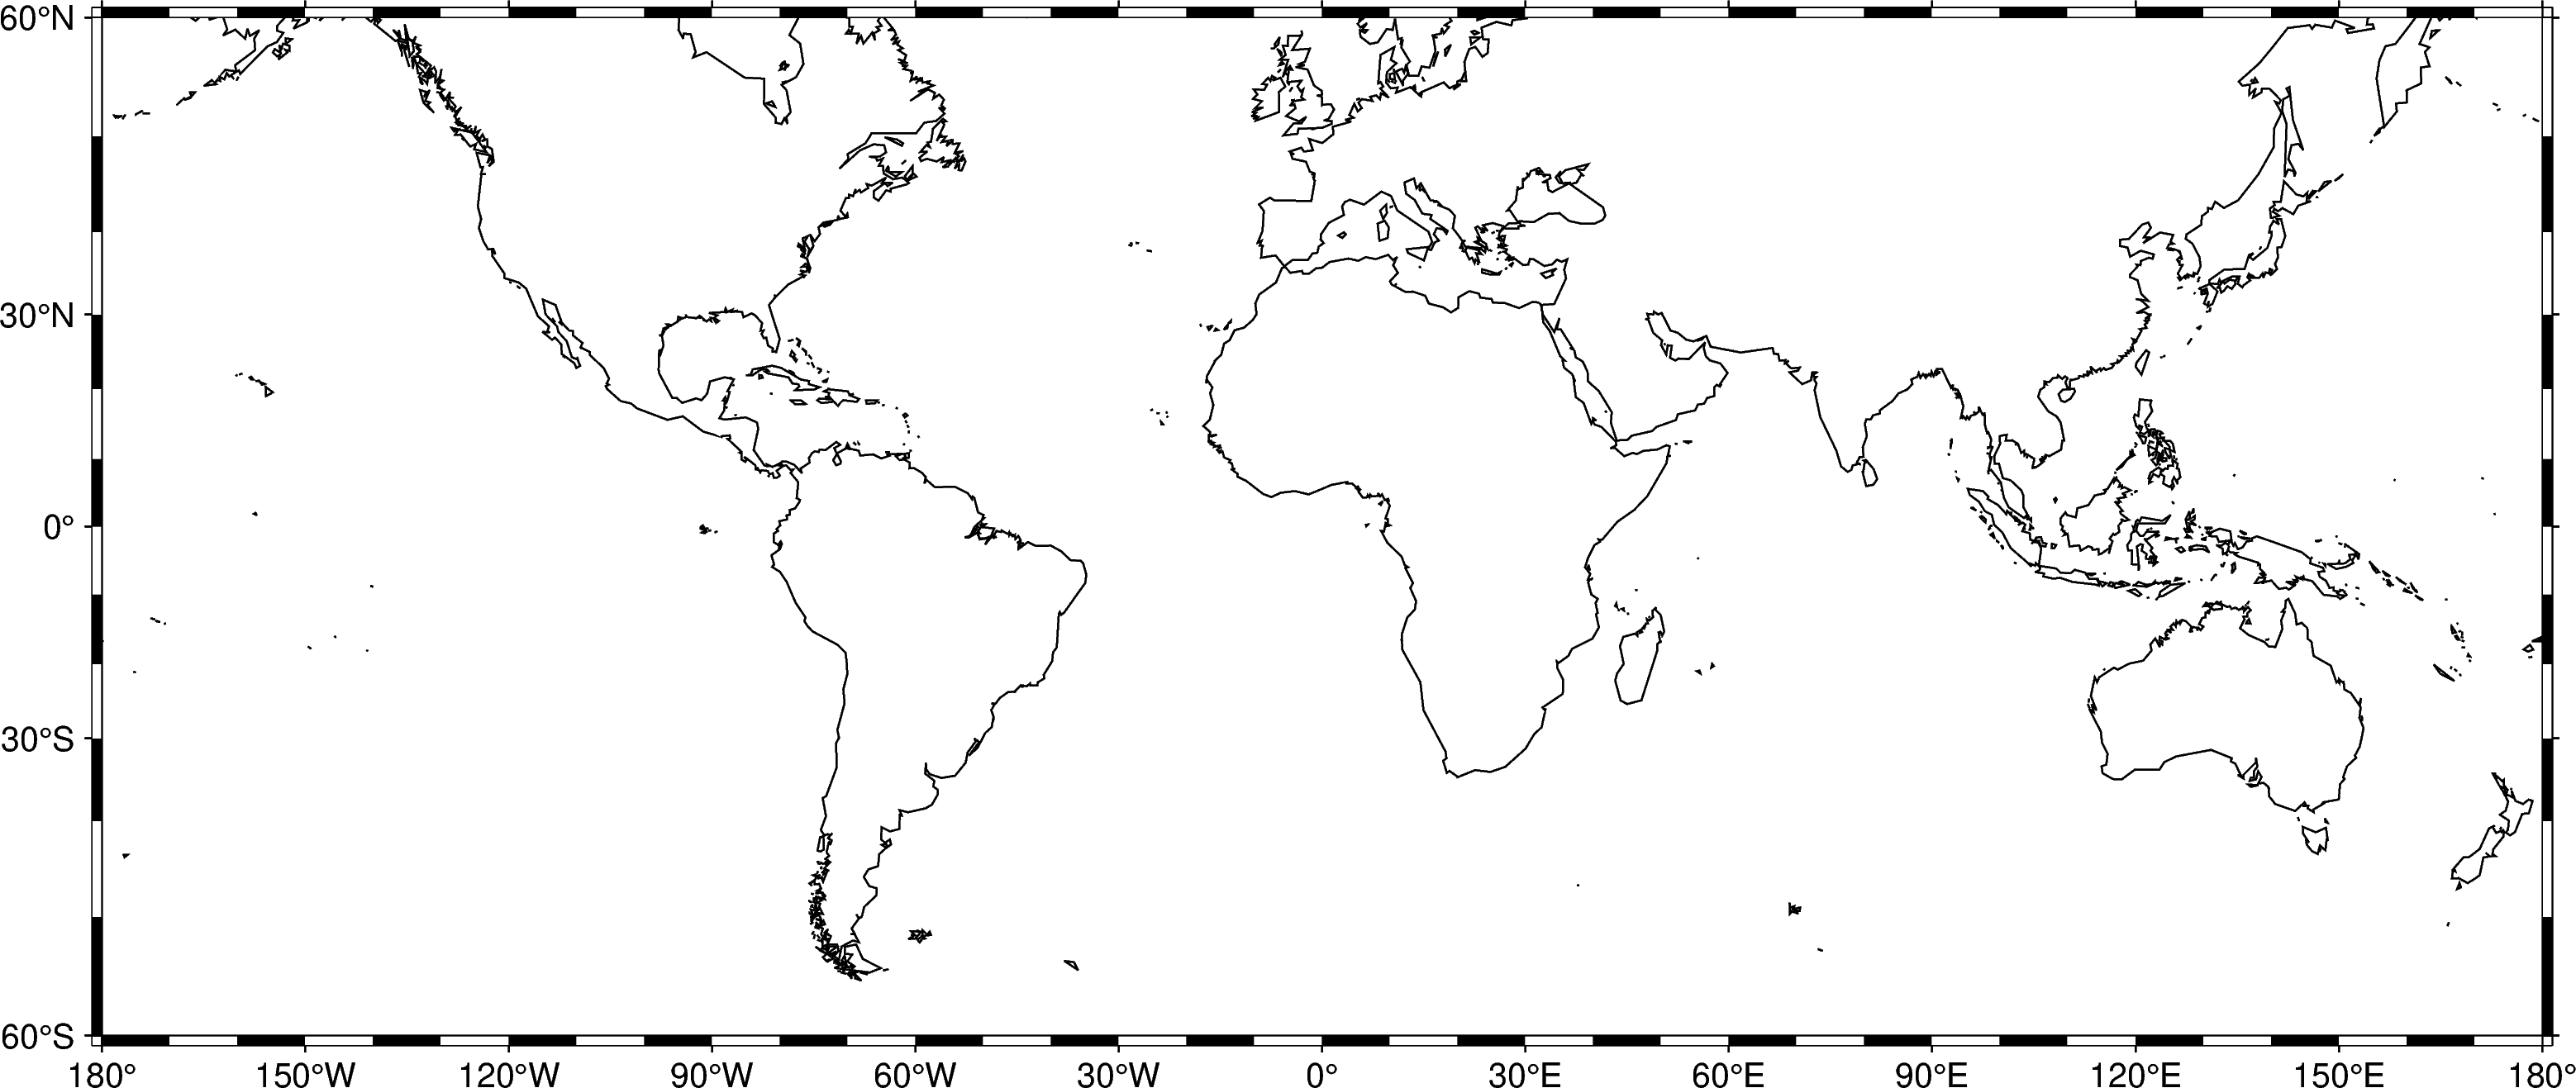

In [70]:
fig = pygmt.Figure()
fig.coast(shorelines="1/0.5p", region=[-180, 180, -60, 60], projection="M25c")
fig.basemap(frame="af")
fig.show(width=800)

We can add gridlines. It takes a bit of work to understand the syntax, but we can add gridlines by adding "g" to our `frame` argument. We can also specify the gridlines spacing (in degrees) by adding numbers after `a`, `f`, or `g`.

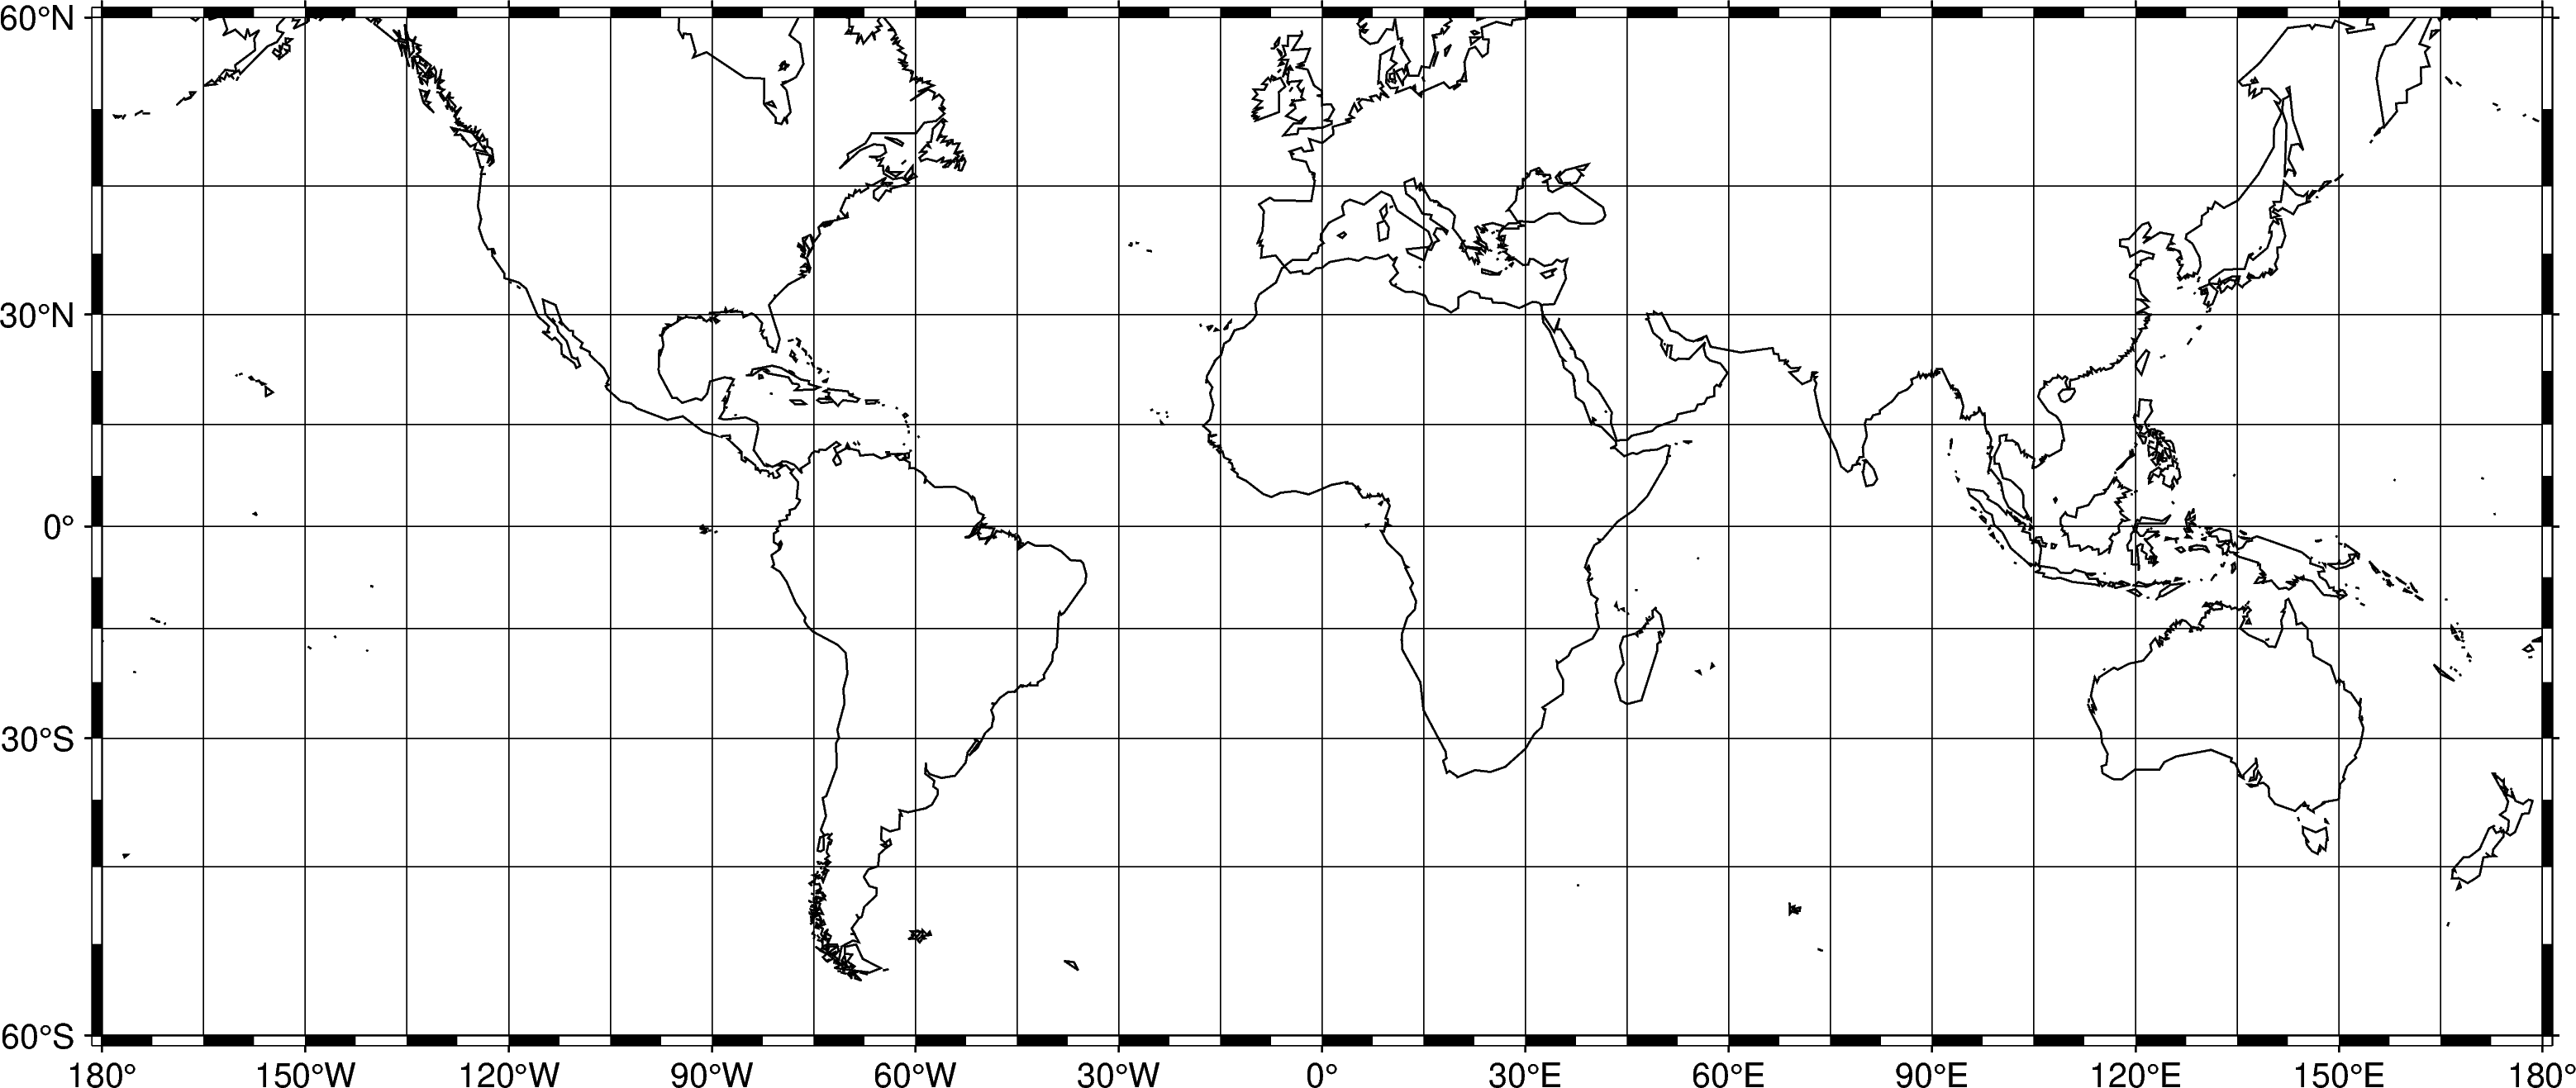

In [71]:
fig = pygmt.Figure()
fig.coast(shorelines="1/0.5p", region=[-180, 180, -60, 60], projection="M25c")
fig.basemap(frame="a30f7.5g15")
fig.show(width=800)

We will end by showing how you can add a title to your plot. Titles get passed to the `frame` argument with a preceding `+t`.

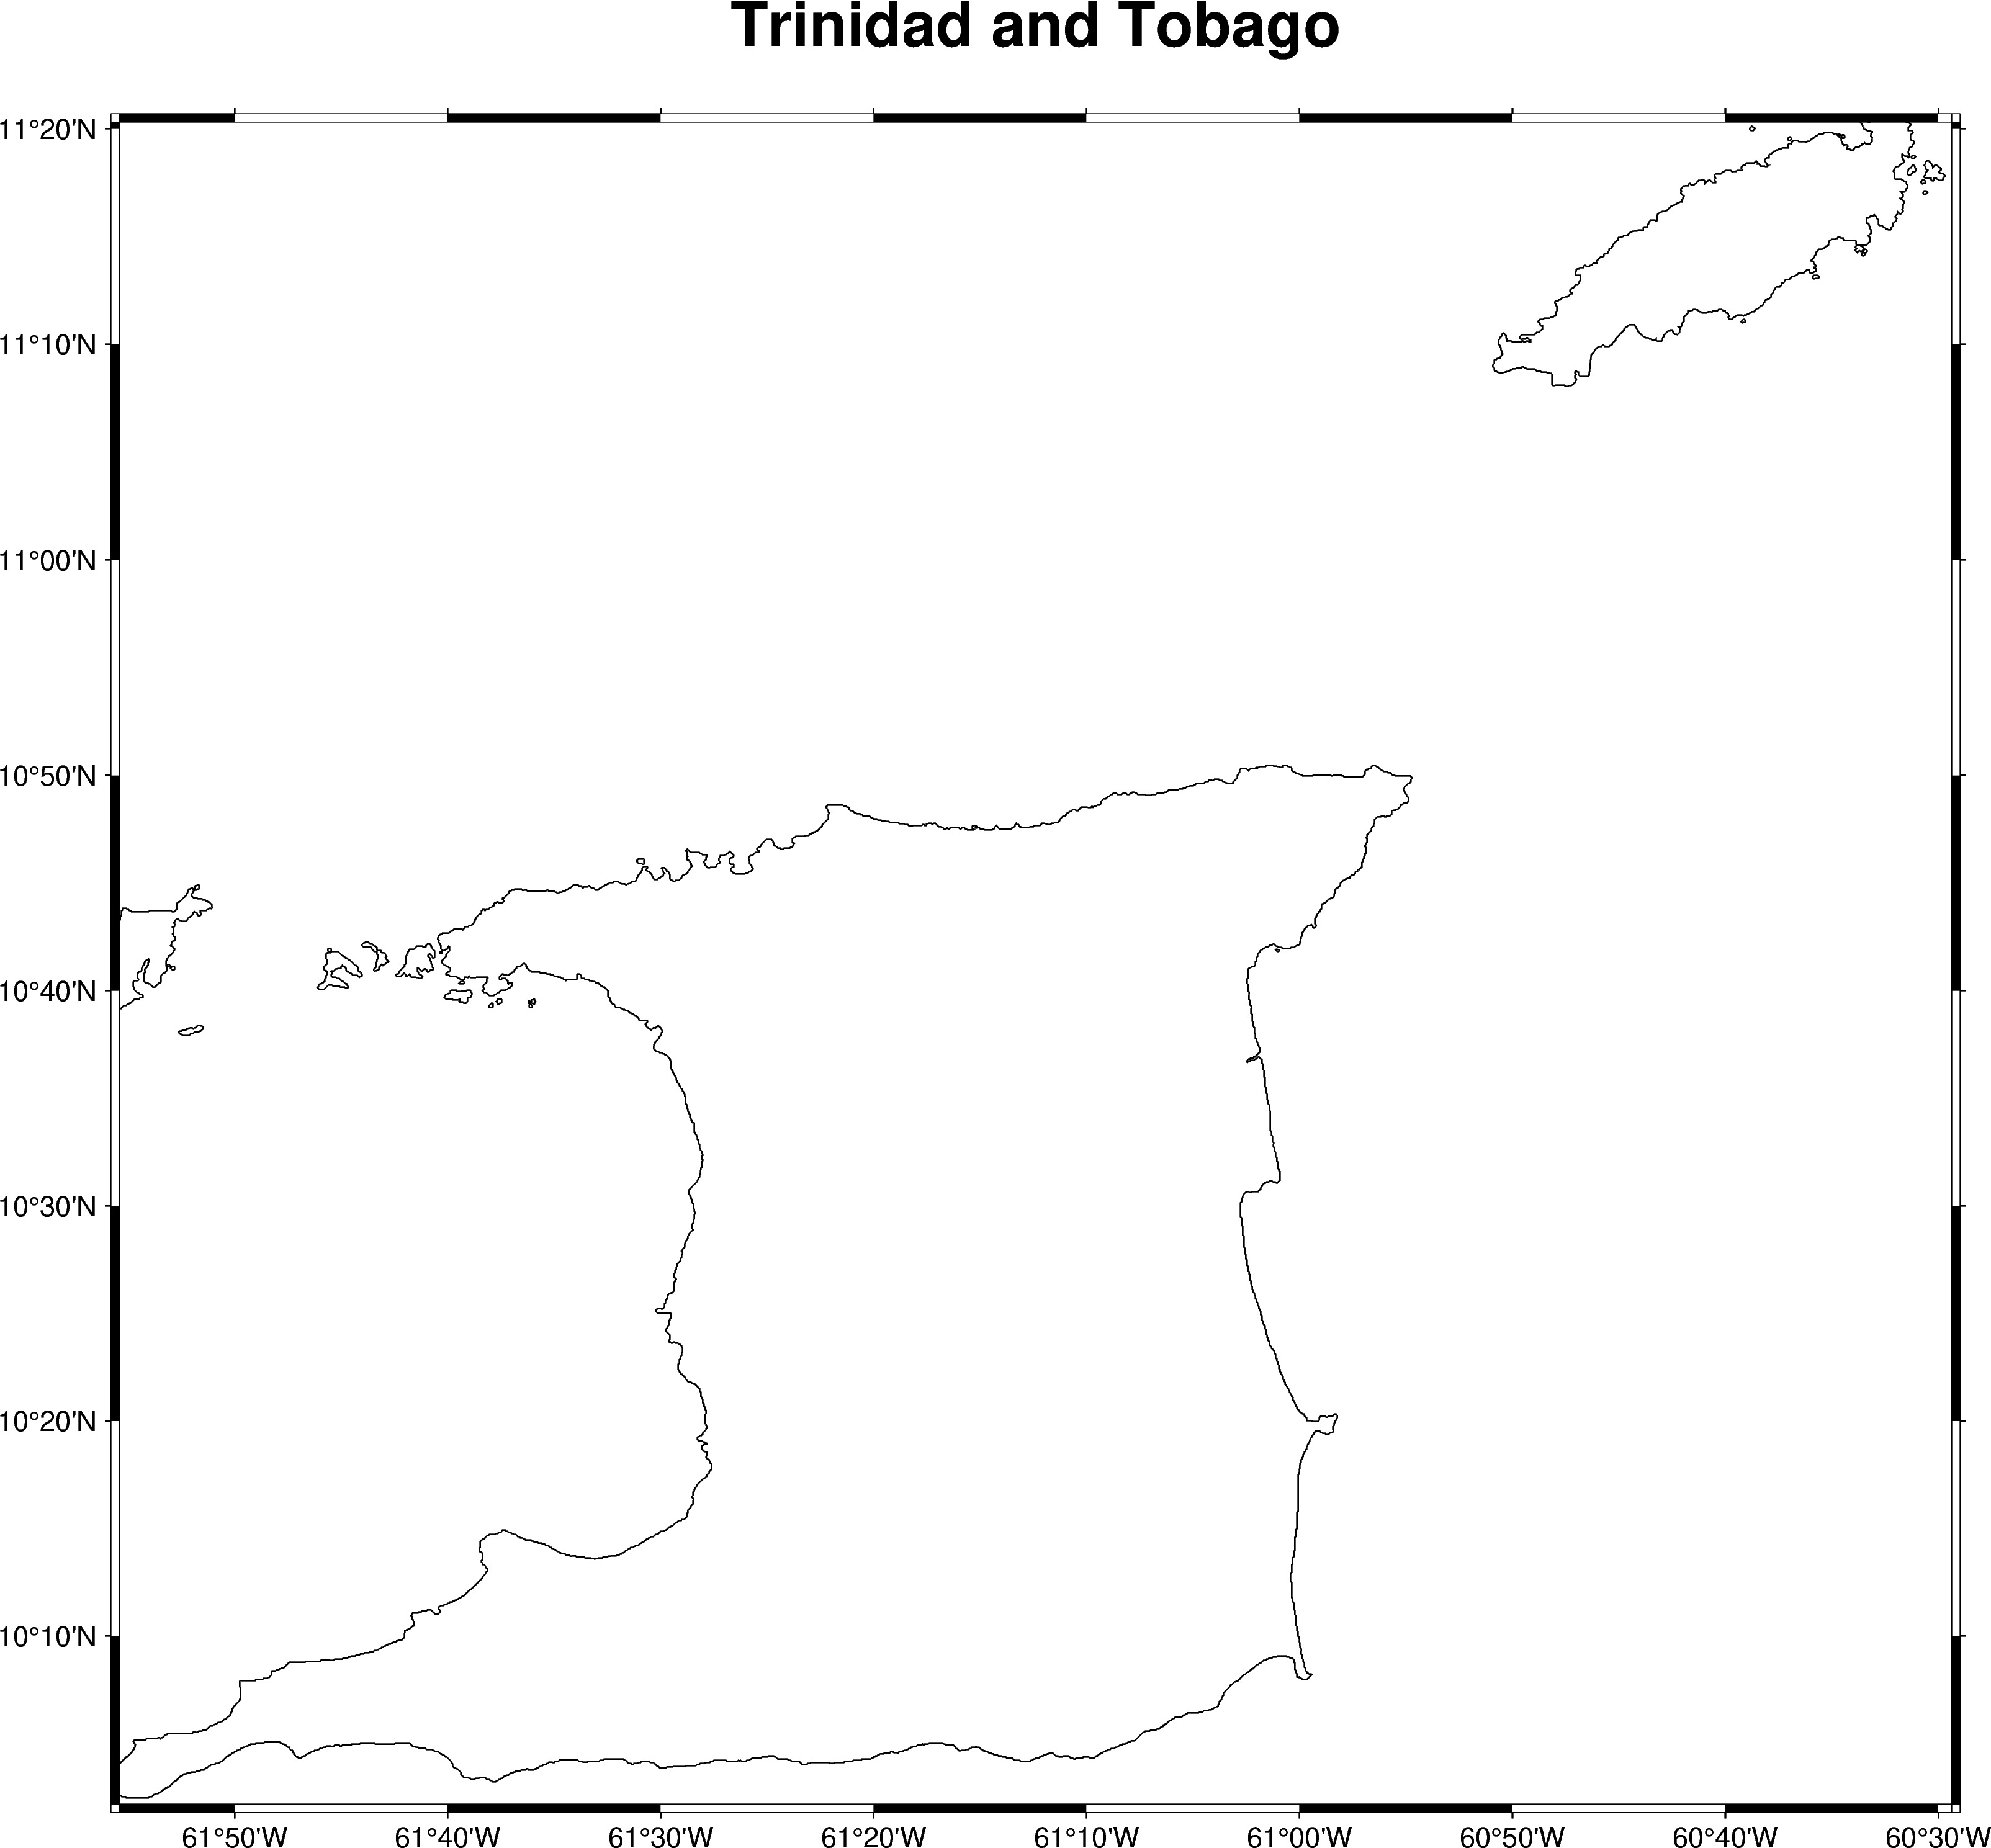

In [72]:
fig = pygmt.Figure()
# region="TT" specifies Trinidad and Tobago using the ISO country code
fig.coast(shorelines="1/0.5p", region="TT", projection="M25c")
fig.basemap(frame=["a", "+tTrinidad and Tobago"])
fig.show(width=800)

### Xarray & PyGMT

In my opinion, Xarray and PyGMT do not work as nicely together as Xarray and Cartopy, but it's getting there. Let's try making a map of our surface air temperature data on a PyGMT map. We will rely on the `grdimage()` function.

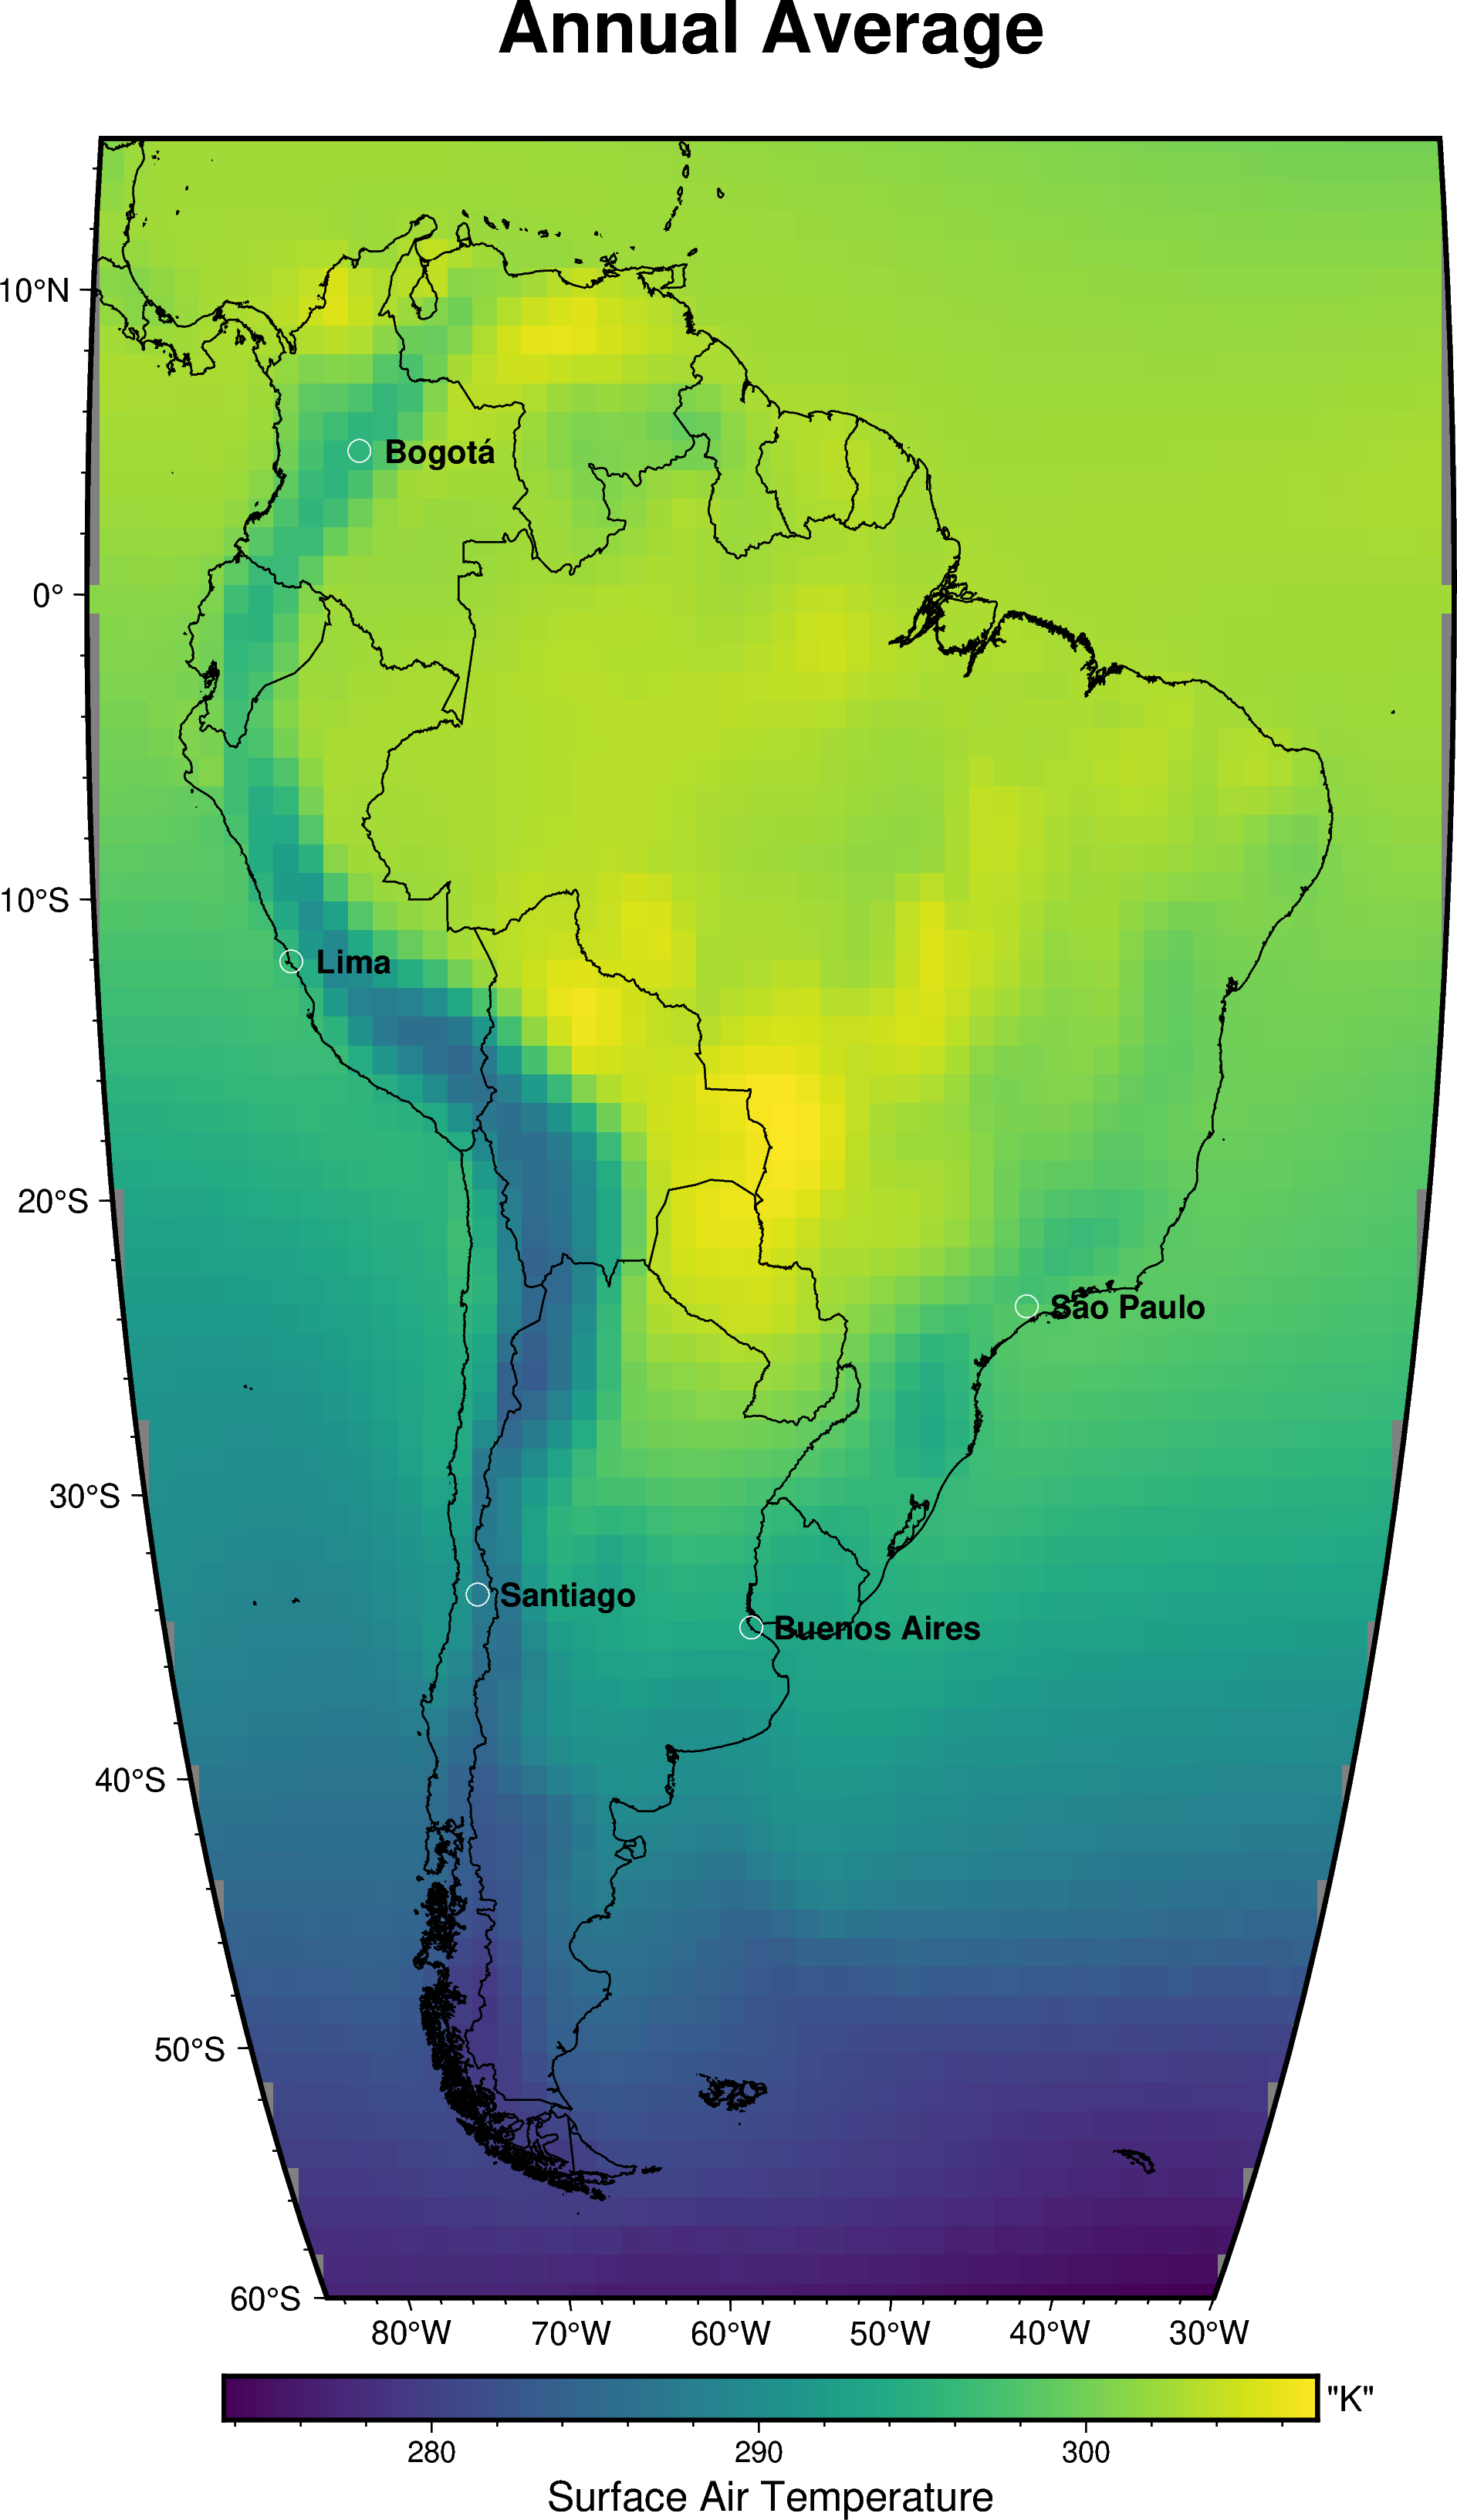

In [73]:
region = [275, 330, -60, 15]  # Set region to South America

# CESM2's lat spacing (~0.94°) doesn't divide evenly into this region,
# which causes a GMT warning. Interpolate to a regular 1° grid first —
# this is the same .interp() we used earlier!
tas_regrid = tas.mean(dim="T").interp(
    lat=np.arange(region[2], region[3] + 1, 1.0),
    lon=np.arange(region[0], region[1] + 1, 1.0),
)

fig = pygmt.Figure()  # Create PyGMT Figure object

# grdimage is PyGMT's equivalent of contourf/pcolormesh in Matplotlib
fig.grdimage(
    grid=tas_regrid,
    region=region,
    cmap="viridis",
    projection="W15c",
    frame=["af", "+tAnnual Average"],  # Adds a title, too
)

# Add coastlines and borders with intermediate resolution
fig.coast(shorelines="1/0.5p,black", resolution="i", borders="1/0.5p,black")

# Add a colorbar. x+l is our colorbar label, f+l is the units
fig.colorbar(frame=['af+l"K"', "x+lSurface Air Temperature"])

# Let's add a few cities on our map
# Define cities
cities = [
    {"name": "Bogotá", "lat": 4.711, "lon": 285.928},
    {"name": "São Paulo", "lat": -23.550, "lon": 313.367},
    {"name": "Buenos Aires", "lat": -34.603, "lon": 301.619},
    {"name": "Lima", "lat": -12.046, "lon": 282.958},
    {"name": "Santiago", "lat": -33.448, "lon": 289.331},
]

# Plot each city
for city in cities:
    fig.plot(x=city["lon"], y=city["lat"], style="c0.25c", pen="white")
    fig.text(
        x=city["lon"] + 1,
        y=city["lat"],
        text=city["name"],
        font="10p,Helvetica-Bold,black",
        justify="LM",
    )

fig.show(width=500)

##### Exercise: Sea level change with Xarray and PyGMT.

Use the code below to read in a CMIP6 model's sea-level variable. Then, calculate the change in sea level between 2015 and 2100. Finally, plot it using PyGMT. Use the "R15c" projection and the "vik" colormap.

*Hints:*
- Select a year's data with `.sel(time=slice("2100-01", "2100-12")).mean("time")`, then subtract the 2015 equivalent.
- `fig.grdimage(grid=..., region="d", projection="R15c", cmap="vik", frame=True)` will plot the data. `"d"` means global domain; `"R15c"` is the Robinson projection.
- Run `pygmt.makecpt(cmap="vik", series=[vmin, vmax, step], symmetric=True)` before `grdimage` to set up the diverging colormap. Choose `vmin`/`vmax` based on the data range.

In [ ]:
import gcsfs

fs = gcsfs.GCSFileSystem(token="anon")

ds = xr.open_zarr(
    "gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Omon/zos/gr/v20180701/",
    consolidated=True,
)
ds


In [ ]:
# Calculate sea-level change

# Make PyGMT figure and plot it


## Extra: Get CMIP6 Data from Google Cloud Storage

**This section is a bonus — we'll only cover it if time permits. Feel free to explore it on your own.**

Source: [Project Pythia CMIP6 Cookbook](https://projectpythia.org/cmip6-cookbook/)

So far, we have been accessing CMIP6 data stored on a server located at Lamont-Doherty Earth Observatory. OPeNDAP is great, but science is generally moving towards cloud-based data storage. Rather than purchasing a server with a fixed lifespan, upkeep costs, and unreliable hardware, universities can pay Google or Amazon to host the data for them. It is more reliable and efficient and still does not require us to have the data on our machines. Below, we look at how we can query and access such data.

Let's start by just looking at the data!

In [74]:
# Imports
import pandas as pd

# Read CSV will read the comma-separated value file on the cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head() # prints the headers and a few lines

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

We can use Pandas' `query()` function to find data matching what we'd like. Below, we look for data from the "historical" experiment, monthly atmospheric means (Amon), and downwelling shortwave radiation at the top of the atmosphere.

In [75]:
df_rsdt = df.query(
    "activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsdt' & experiment_id == 'historical'"
)
df_rsdt


activity_id       institution_id     source_id experiment_id  \
6230          CMIP            NOAA-GFDL      GFDL-CM4    historical   
22160         CMIP                 IPSL  IPSL-CM6A-LR    historical   
22305         CMIP                 IPSL  IPSL-CM6A-LR    historical   
22469         CMIP                 IPSL  IPSL-CM6A-LR    historical   
22821         CMIP                 IPSL  IPSL-CM6A-LR    historical   
...            ...                  ...           ...           ...   
501573        CMIP  EC-Earth-Consortium     EC-Earth3    historical   
501771        CMIP  EC-Earth-Consortium     EC-Earth3    historical   
501785        CMIP  EC-Earth-Consortium     EC-Earth3    historical   
502504        CMIP  EC-Earth-Consortium     EC-Earth3    historical   
512345        CMIP                 CMCC     CMCC-ESM2    historical   

        member_id table_id variable_id grid_label  \
6230     r1i1p1f1     Amon        rsdt        gr1   
22160    r8i1p1f1     Amon        rsdt         gr   
22305    r2i1p1f1     Amon        rsdt         gr   
22469   r30i1p1f1     Amon        rsdt         gr   
22821   r31i1p1f1     Amon        rsdt         gr   
...           ...      ...         ...        ...   
501573   r2i1p1f1     Amon        rsdt         gr   
501771   r7i1p1f1     Amon        rsdt         gr   
501785  r14i1p1f1     Amon        rsdt         gr   
502504  r10i1p1f1     Amon        rsdt         gr   
512345   r1i1p1f1     Amon        rsdt         gn   

                                                   zstore  dcpp_init_year  \
6230    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...             NaN   
22160   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22305   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22469   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22821   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
...                                                   ...             ...   
501573  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
501771  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
501785  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
502504  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   
512345  gs://cmip6/CMIP6/CMIP/CMCC/CMCC-ESM2/historica...             NaN   

         version  
6230    20180701  
22160   20180803  
22305   20180803  
22469   20180803  
22821   20180803  
...          ...  
501573  20201215  
501771  20201217  
501785  20201218  
502504  20201221  
512345  20210114  

[560 rows x 11 columns]

We can further refine by finding experiments from NCAR.

In [76]:
df_rsdt_ncar = df_rsdt.query('institution_id == "NCAR"')
df_rsdt_ncar

activity_id institution_id        source_id experiment_id  member_id  \
56041         CMIP           NCAR      CESM2-WACCM    historical   r2i1p1f1   
56088         CMIP           NCAR      CESM2-WACCM    historical   r3i1p1f1   
56272         CMIP           NCAR      CESM2-WACCM    historical   r1i1p1f1   
59784         CMIP           NCAR            CESM2    historical   r1i1p1f1   
61847         CMIP           NCAR            CESM2    historical   r5i1p1f1   
62716         CMIP           NCAR            CESM2    historical   r2i1p1f1   
63105         CMIP           NCAR            CESM2    historical   r3i1p1f1   
63263         CMIP           NCAR            CESM2    historical   r6i1p1f1   
63372         CMIP           NCAR            CESM2    historical   r4i1p1f1   
64606         CMIP           NCAR            CESM2    historical   r8i1p1f1   
64921         CMIP           NCAR            CESM2    historical   r7i1p1f1   
64982         CMIP           NCAR            CESM2    historical   r9i1p1f1   
66375         CMIP           NCAR            CESM2    historical  r10i1p1f1   
200764        CMIP           NCAR            CESM2    historical  r11i1p1f1   
384129        CMIP           NCAR  CESM2-WACCM-FV2    historical   r1i1p1f1   
385315        CMIP           NCAR        CESM2-FV2    historical   r1i1p1f1   
420691        CMIP           NCAR  CESM2-WACCM-FV2    historical   r3i1p1f1   
421213        CMIP           NCAR  CESM2-WACCM-FV2    historical   r2i1p1f1   
421998        CMIP           NCAR        CESM2-FV2    historical   r3i1p1f1   
422524        CMIP           NCAR        CESM2-FV2    historical   r2i1p1f1   

       table_id variable_id grid_label  \
56041      Amon        rsdt         gn   
56088      Amon        rsdt         gn   
56272      Amon        rsdt         gn   
59784      Amon        rsdt         gn   
61847      Amon        rsdt         gn   
62716      Amon        rsdt         gn   
63105      Amon        rsdt         gn   
63263      Amon        rsdt         gn   
63372      Amon        rsdt         gn   
64606      Amon        rsdt         gn   
64921      Amon        rsdt         gn   
64982      Amon        rsdt         gn   
66375      Amon        rsdt         gn   
200764     Amon        rsdt         gn   
384129     Amon        rsdt         gn   
385315     Amon        rsdt         gn   
420691     Amon        rsdt         gn   
421213     Amon        rsdt         gn   
421998     Amon        rsdt         gn   
422524     Amon        rsdt         gn   

                                                   zstore  dcpp_init_year  \
56041   gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...             NaN   
56088   gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...             NaN   
56272   gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...             NaN   
59784   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
61847   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...             NaN   
62716   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...             NaN   
63105   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...             NaN   
63263   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...             NaN   
63372   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...             NaN   
64606   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...             NaN   
64921   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r7...             NaN   
64982   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r9...             NaN   
66375   gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
200764  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...             NaN   
384129  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/his...             NaN   
385315  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historica...             NaN   
420691  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/his...             NaN   
421213  gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/his...             NaN   
4

Let's try loading in the data, just the first one on the DataFrame above.

In [77]:
# get the path to a specific zarr store
zstore = df_rsdt_ncar.zstore.values[-1]
print(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(zstore, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NCAR/CESM2-FV2/historical/r2i1p1f1/Amon/rsdt/gn/v20200226/


<xarray.Dataset> Size: 110MB
Dimensions:    (time: 1980, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    lat_bnds   (lat, nbnd) float64 2kB ...
    lon_bnds   (lon, nbnd) float64 2kB ...
    time_bnds  (time, nbnd) object 32kB ...
Dimensions without coordinates: nbnd
Data variables:
    rsdt       (time, lat, lon) float32 109MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  10950.0
    case_id:                1560
    ...                     ...
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/0b5f3246-494e-4a76-b031-901916d45524...
    variable_id:            rsdt
    variant_info:           CMIP6 CESM2-FV2 historical experiment (1850-2014)...
    variant_label:          r2i1p1f1

And we can use the data exactly like how we were when we were accessing it from OPeNDAP. However, be careful! The dimensions and coordinate names are slightly different.

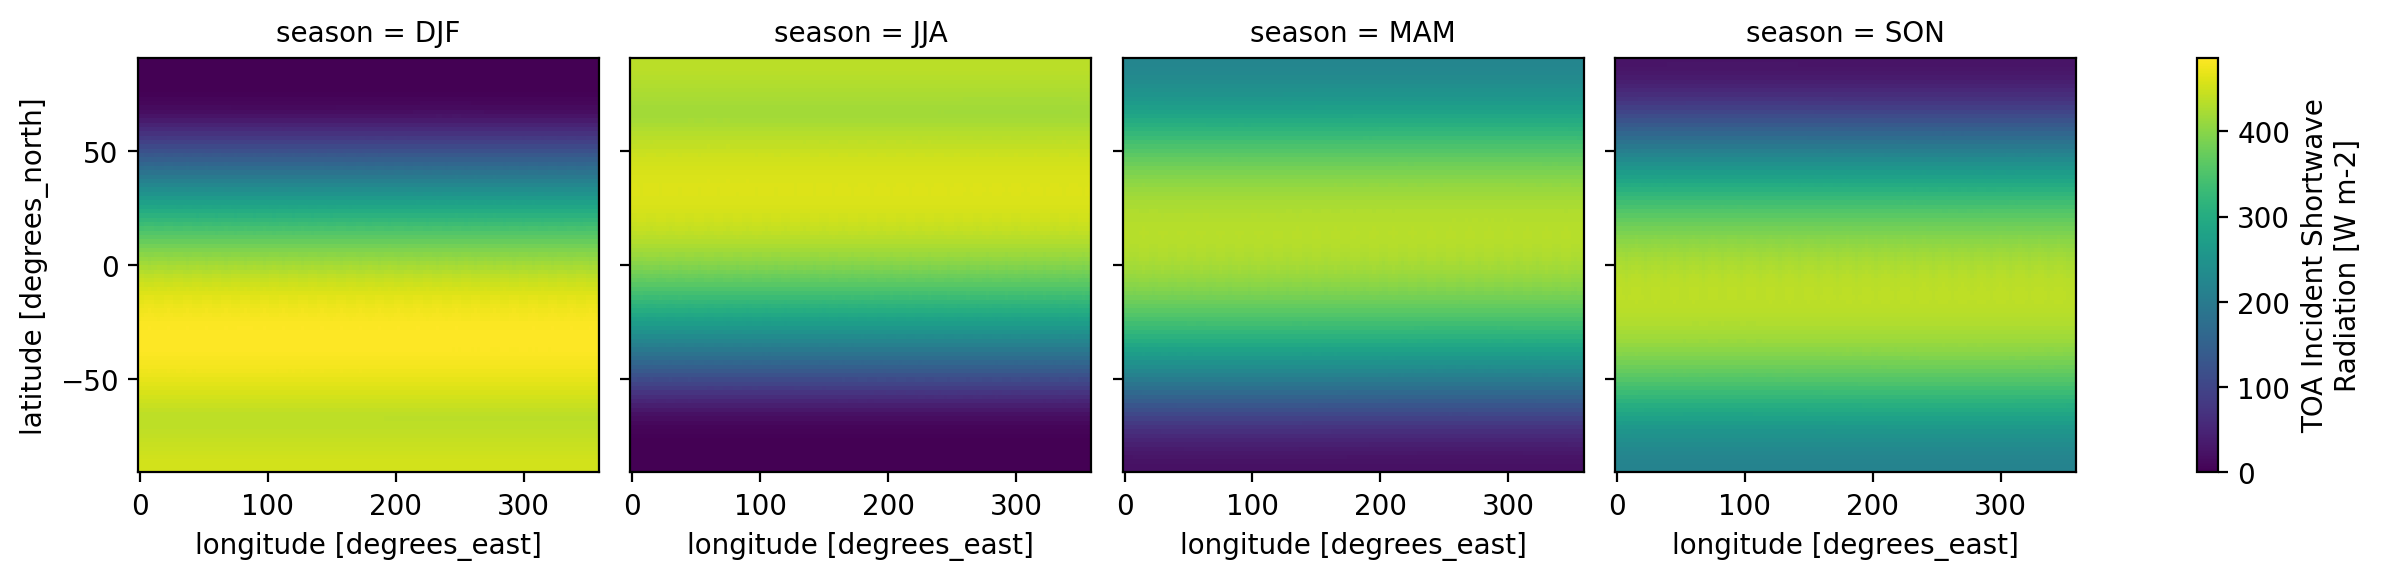

In [78]:
ds.rsdt.groupby("time.season").mean(dim="time").plot(col="season")